# Quantifying 15-Minute City Spatial Structure:
# Exploring Its Influence on Transport Emissions in London's CZ


In [1]:
# General Python Utilities
import os
import glob
import time
import csv
import json
import re
import codecs

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import numpy

import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning and Statistics
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

import lightgbm as lgb
from lightgbm import LGBMRegressor

import joblib


# Image and File Handling
from PIL import Image
import PIL.Image
# install OpenCV by input 'pip install opencv-python' in terminal
# import cv2

# Machine Learning Model Utilities
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
import rfpimp

# Web and Network Requests
import requests

# Geospatial Analysis
import geopandas as gpd
import libpysal as lps
import esda
from shapely.geometry import Point

import networkx as nx
import osmnx as ox

# PyTorch Libraries (specific to semantic segmentation and scene parsing)
import torch
import torchvision.transforms
import scipy.io

## 1. Perceived Streetscape quality Analysis: Built predictive model

### 1.1 Process training data: Place Pulse 2.0-the imagery and perceived socre in 6 dimensions

In [ ]:
# Check the perceived score of dataset
df = pd.read_csv('image_download_segmentation/place-pulse-2.0/qscores.csv', encoding='utf-8')
df

_id               location_id  num_votes  \
0       51e048d4fdc9f01d25aab793  5185d46bfdc9f03fd50013d5          5   
1       51e048c9fdc9f01d25a9a084  513cbed8fdc9f035870011fe          2   
2       51e048a7fdc9f01d25a67f6e  513e5fd7fdc9f0358700b2d7          4   
3       5217c360ad93a7d3e7b1d181  50f5eaf6fdc9f065f0007ef8          6   
4       51e0489dfdc9f01d25a59df7  5185d4defdc9f03fd500143b          6   
...                          ...                       ...        ...   
668335  51e048acfdc9f01d25a6f6a5  513cdb38fdc9f03587002037         13   
668336  51e048abfdc9f01d25a6d52c  5140cc05fdc9f04926002cce          9   
668337  51e048a1fdc9f01d25a60099  50f43b71fdc9f065f00030d3         10   
668338  51e048a0fdc9f01d25a5dbb6  50f5e701fdc9f065f0006f04         15   
668339  51e048bffdc9f01d25a8adf0  513cef6ffdc9f0358700242c          5   

                        place_id                  study_id  trueskill.score  \
0       50f38816fdc9f065f0000364  50f62cb7a84ea7c5fdd2e458        36.502702   
1       50e5f30fd7c3df413b000303  50f62cb7a84ea7c5fdd2e458        32.762342   
2       50e6fcabd7c3df413b000aa6  50f62c41a84ea7c5fdd2e454        26.115423   
3       50f38e44fdc9f065f0000855  5217c351ad93a7d3e7b07a64        17.800618   
4       50f38816fdc9f065f0000364  50a68a51fdc9f05596000002        12.561016   
...                          ...                       ...              ...   
668335  50e745a4d7c3df413b00127a  50f62c41a84ea7c5fdd2e454        27.128087   
668336  50e735e8d7c3df413b000f54  50f62c41a84ea7c5fdd2e454        25.036504   
668337  50f39725fdc9f065f0000c38  50a68a51fdc9f05596000002        24.235321   
668338  50f39092fdc9f065f000097d  50a68a51fdc9f05596000002        17.335245   
668339  50e745a4d7c3df413b00127a  50f62c68a84ea7c5fdd2e456        20.979986   

        trueskill.stds.-1  
0                4.724535  
1                6.070995  
2                4.384154  
3                4.003182  
4                3.885248  
...                   ...  
668335           2.505120  
668336           3.157734  
668337           3.141033  
668338           2.468244  
668339           3.989348  

[668340 rows x 7 columns]

In [ ]:
# Define the final percieved score calculation rule. 4 positive scores minus 2 negative socres.

add_ids = ['50a68a51fdc9f05596000002', '50f62c41a84ea7c5fdd2e454', '50f62cb7a84ea7c5fdd2e458', '5217c351ad93a7d3e7b07a64'] # Safety, livelier, wealthier, more beautiful
subtract_ids = ['50f62c68a84ea7c5fdd2e456', '50f62ccfa84ea7c5fdd2e459'] # more depressing, more boring

# function of calculating final percieved socre
def calc_final_score(group):
    add_scores = group[group['study_id'].isin(add_ids)]['trueskill.score'].sum()
    subtract_scores = group[group['study_id'].isin(subtract_ids)]['trueskill.score'].sum()
    score = add_scores - subtract_scores
    return score

# Calculate the final score for each location_id
# we got a series, only index and value, including groupID and result score, need to use groupID to join with original data.
# Use .reset_index() transform to dataframe
final_scores= df.groupby('location_id').apply(calc_final_score).reset_index()
final_scores.columns = ['location_id', 'final_score']

# Merge with original DataFrame
df = pd.merge(df, final_scores, on='location_id', how='left')


C:\Users\99787\AppData\Local\Temp\ipykernel_3596\1951495835.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_scores= df.groupby('location_id').apply(calc_final_score).reset_index()


In [ ]:
# Show the results and save to local
df = df.drop_duplicates(subset='location_id')
df = df[['location_id', 'final_score']]

# 将结果保存为CSV文件
df.to_csv('Place_Pulse_2.0/quality_score.csv', index=False)

df

location_id  final_score
0       5185d46bfdc9f03fd50013d5    27.421300
1       513cbed8fdc9f035870011fe    32.028161
2       513e5fd7fdc9f0358700b2d7    21.359137
3       50f5eaf6fdc9f065f0007ef8    17.800618
4       5185d4defdc9f03fd500143b    17.864893
...                          ...          ...
537047  50f44800fdc9f065f0003bf7    21.778817
537160  513d8000fdc9f0358700767d    18.442698
543857  513d3347fdc9f03587002951    34.285460
555900  514217fafdc9f049260080b8    26.652280
575247  50f5eb44fdc9f065f0008158    24.311681

[111390 rows x 2 columns]

### 1.2 Imagery semantic segmentation for training imagery (Place-Pulse-2.0) and google street images of CAZ

In [ ]:
# %%
start_time = time.time()
# Define a function to get the segmented images result
def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
    #         print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    # im_vis = numpy.concatenate((img, pred_color), axis=1)
    # display(PIL.Image.fromarray(im_vis))
    return pred_color

# read the color file, based on which the segmented elements could be colored and record in csv correctly.
colors = scipy.io.loadmat('image_download_segmentation/semantic_segmentation/data/color150.mat')['colors']
names = {}
with open('image_download_segmentation/semantic_segmentation/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='image_download_segmentation/semantic_segmentation/ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='image_download_segmentation/semantic_segmentation/ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

segmentation_module.eval()
segmentation_module.cpu()
# segmentation_module.cuda()
# print(segmentation_module.eval())
# print(segmentation_module.cpu())

# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])])  # across a large photo dataset.

# Process the segmentation process with training images and LondonCAZ images

# Filepath of image storage, image result storage, the csv result storage
# process training images, place- pulse-2.0
images_storage_path = r'image_download_segmentation/place-pulse-2.0/images'
image_result_path = r'image_download_segmentation/semantic_segmentation/training_segmentation_images'
image_result_csv = r'image_download_segmentation/semantic_segmentation/training_segmentation_result.csv'

# # process LondonCAZ images
# images_storage_path = r'image_download_segmentation/LondonCAZ_images'
# image_result_path = r'image_download_segmentation/semantic_segmentation/LondonCAZ_segmentation_images'
# image_result_csv = r'image_download_segmentation/semantic_segmentation/segmentation_result_CAZ.csv'

# Set the saved id figures
id_save = 50

# Set table headers
headers = ['id', ]
for id_num in range(id_save):
    head = 'id%d' % (id_num + 1)
    headers.append(head)

# Create csv file and table hearders
with open('%s' % image_result_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

for i, j, k in os.walk(images_storage_path):
    for image_name in k:
        image_name_path = '{}/{}'.format(i, image_name)

        pil_image = PIL.Image.open(image_name_path).convert('RGB')
        img_original = numpy.array(pil_image)
        img_data = pil_to_tensor(pil_image)
        singleton_batch = {'img_data': img_data[None].cpu()}
        # singleton_batch = {'img_data': img_data[None].cuda()}
        output_size = img_data.shape[1:]

        with torch.no_grad():
            scores = segmentation_module(singleton_batch, segSize=output_size)

        # Get the predicted scores for each pixel
        _, pred = torch.max(scores, dim=1)
        pred = pred.cpu()[0].numpy()
        # Get the segmentation results
        vs_total = visualize_result(img_original, pred)
        # Restore segmented images
        image = PIL.Image.fromarray(vs_total)
        image.save('{}/{}'.format(image_result_path, image_name))

        # Create list to restore results
        rate_list = ['%s' % image_name, ]
        for n in range(id_save):
            # vs_single is the single element proportion image
            vs_single = visualize_result(img_original, pred, n)
            # Calculate proportion of the element in whole picture
            num = np.count_nonzero((vs_single != [0, 0, 0]).all(axis=2))
            all_num = vs_single.shape[0] * vs_single.shape[1]
            rate = num / all_num
            rate_list.append(rate)

        # Wirrte the result to csv
        with open('%s' % image_result_csv, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(rate_list)

        print(' [-] Successfully process：', image_name_path)
end_time = time.time()
print(' [-] Successfully process all images,time-consuming{:.2f}秒'.format(end_time - start_time))

In [ ]:
# Process the segmentation results of training dataset
seg_result = pd.read_csv('image_download_segmentation/semantic_segmentation/training_segmentation_result.csv')

# extract contents in id column that we need
seg_result['id'] = seg_result['id'].apply(lambda x: x.split('_')[2])

# save DataFrame
df.to_csv('image_download_segmentation/training_segmentation_modified.csv', index=False)

# print to check
print(seg_result)

                              id       id1       id2       id3  id4       id5  \
0       50f560f4fdc9f065f0005365  0.000000  0.035242  0.206092  0.0  0.269108   
1       50f56204fdc9f065f00058b7  0.000192  0.100042  0.241017  0.0  0.160883   
2       50f562e3fdc9f065f0005b4a  0.000008  0.003683  0.018900  0.0  0.515167   
3       50f56198fdc9f065f000559f  0.000000  0.004742  0.159808  0.0  0.362258   
4       50f560fbfdc9f065f00053f1  0.006658  0.011383  0.180767  0.0  0.323842   
...                          ...       ...       ...       ...  ...       ...   
110983  5141341ffdc9f04926004536  0.006033  0.140583  0.346050  0.0  0.041325   
110984  5141351afdc9f049260048c2  0.000000  0.028983  0.205025  0.0  0.294842   
110985  514134f1fdc9f0492600483a  0.000717  0.000000  0.031108  0.0  0.576425   
110986  51413380fdc9f04926004310  0.000608  0.016083  0.286600  0.0  0.215300   
110987  5141357bfdc9f04926004a0c  0.000000  0.062408  0.327767  0.0  0.132767   

        id6       id7  id8 

In [ ]:
# merge the perceived score with semantic segregation result, get the dependent and independent variables
merged_df = pd.merge(seg_result, df, left_on='id', right_on='location_id', how='left')

merged_df.drop(columns=['location_id'], inplace=True)

merged_df.rename(columns={'final_score': 'score'}, inplace=True)
merged_df.rename(columns={'id': 'viewpoint_id'}, inplace=True)

In [ ]:
print("Merged DataFrame:\n", merged_df)

Merged DataFrame:
                     viewpoint_id       id1       id2       id3  id4       id5  \
0       50f560f4fdc9f065f0005365  0.000000  0.035242  0.206092  0.0  0.269108   
1       50f56204fdc9f065f00058b7  0.000192  0.100042  0.241017  0.0  0.160883   
2       50f562e3fdc9f065f0005b4a  0.000008  0.003683  0.018900  0.0  0.515167   
3       50f56198fdc9f065f000559f  0.000000  0.004742  0.159808  0.0  0.362258   
4       50f560fbfdc9f065f00053f1  0.006658  0.011383  0.180767  0.0  0.323842   
...                          ...       ...       ...       ...  ...       ...   
110983  5141341ffdc9f04926004536  0.006033  0.140583  0.346050  0.0  0.041325   
110984  5141351afdc9f049260048c2  0.000000  0.028983  0.205025  0.0  0.294842   
110985  514134f1fdc9f0492600483a  0.000717  0.000000  0.031108  0.0  0.576425   
110986  51413380fdc9f04926004310  0.000608  0.016083  0.286600  0.0  0.215300   
110987  5141357bfdc9f04926004a0c  0.000000  0.062408  0.327767  0.0  0.132767   

        

In [ ]:
# join lat and lng colomns

loc = pd.read_csv('locations.csv')

merged_id_loc = pd.merge(merged_df, loc[['_id', 'lat', 'lng']], left_on='viewpoint_id', right_on='_id', how='left')

merged_id_loc.drop(columns=['_id'], inplace=True)

# move 'lat', 'lng' to second and third
merged_id_loc.insert(1, 'lat', merged_id_loc.pop('lat'))
merged_id_loc.insert(2, 'lng', merged_id_loc.pop('lng'))

# svae csv
merged_id_loc.to_csv('image_download_segmentation/training_features_score.csv', index=False)

merged_id_loc

viewpoint_id        lat         lng       id1       id2  \
0       50f560f4fdc9f065f0005365   1.262675  103.804794  0.000000  0.035242   
1       50f56204fdc9f065f00058b7   1.263947  103.823818  0.000192  0.100042   
2       50f562e3fdc9f065f0005b4a   1.264260  103.803093  0.000008  0.003683   
3       50f56198fdc9f065f000559f   1.264882  103.806119  0.000000  0.004742   
4       50f560fbfdc9f065f00053f1   1.264959  103.804580  0.006658  0.011383   
...                          ...        ...         ...       ...       ...   
110983  5141341ffdc9f04926004536  60.277422   24.973295  0.006033  0.140583   
110984  5141351afdc9f049260048c2  60.277591   25.015701  0.000000  0.028983   
110985  514134f1fdc9f0492600483a  60.277987   25.025202  0.000717  0.000000   
110986  51413380fdc9f04926004310  60.278803   24.995722  0.000608  0.016083   
110987  5141357bfdc9f04926004a0c  60.279112   25.010524  0.000000  0.062408   

             id3  id4       id5  id6       id7  ...  id42  id43      id44  \
0       0.206092  0.0  0.269108  0.0  0.172967  ...     0   0.0  0.000000   
1       0.241017  0.0  0.160883  0.0  0.295967  ...     0   0.0  0.003933   
2       0.018900  0.0  0.515167  0.0  0.008458  ...     0   0.0  0.000000   
3       0.159808  0.0  0.362258  0.0  0.181633  ...     0   0.0  0.000000   
4       0.180767  0.0  0.323842  0.0  0.319825  ...     0   0.0  0.000000   
...          ...  ...       ...  ...       ...  ...   ...   ...       ...   
110983  0.346050  0.0  0.041325  0.0  0.311725  ...     0   0.0  0.000000   
110984  0.205025  0.0  0.294842  0.0  0.303350  ...     0   0.0  0.000000   
110985  0.031108  0.0  0.576425  0.0  0.208125  ...     0   0.0  0.000000   
110986  0.286600  0.0  0.215300  0.0  0.394408  ...     0   0.0  0.000000   
110987  0.327767  0.0  0.132767  0.0  0.423350  ...     0   0.0  0.000000   

        id45  id46  id47  id48  id49  id50      score  
0        0.0   0.0   0.0     0   0.0   0.0  26.854949  
1        0.0   0.0   0.0     0   0.0   0.0  34.423031  
2        0.0   0.0   0.0     0   0.0   0.0  33.533368  
3        0.0   0.0   0.0     0   0.0   0.0  26.005591  
4        0.0   0.0   0.0     0   0.0   0.0  18.752561  
...      ...   ...   ...   ...   ...   ...        ...  
110983   0.0   0.0   0.0     0   0.0   0.0  25.028916  
110984   0.0   0.0   0.0     0   0.0   0.0  24.715594  
110985   0.0   0.0   0.0     0   0.0   0.0  21.733342  
110986   0.0   0.0   0.0     0   0.0   0.0  20.230450  
110987   0.0   0.0   0.0     0   0.0   0.0  23.322643  

[110988 rows x 54 columns]

In [3]:
# output training dataset information. Calculate std and median of 6 dimension perceived qualities

df = pd.read_csv('image_download_segmentation/place-pulse-2.0/qscores.csv')

# define 6 dimensions columns code
study_ids = ['50a68a51fdc9f05596000002', '50f62c41a84ea7c5fdd2e454', '50f62c68a84ea7c5fdd2e456',
             '50f62cb7a84ea7c5fdd2e458', '50f62ccfa84ea7c5fdd2e459', '5217c351ad93a7d3e7b07a64']

# calculate 6 dimension qualities
for study_id in study_ids:

    study_data = df[df['study_id'] == study_id]
    
    median_score = study_data['trueskill.score'].median()
    sd_score = study_data['trueskill.score'].std()
    
    # print
    print(f"Study ID: {study_id}")
    print(f"Median Score: {median_score:.2f}")
    print(f"Standard Deviation Score: {sd_score:.2f}")
    print("---")

Study ID: 50a68a51fdc9f05596000002
Median Score: 25.00
Standard Deviation Score: 4.54
---
Study ID: 50f62c41a84ea7c5fdd2e454
Median Score: 25.00
Standard Deviation Score: 4.97
---
Study ID: 50f62c68a84ea7c5fdd2e456
Median Score: 25.00
Standard Deviation Score: 5.05
---
Study ID: 50f62cb7a84ea7c5fdd2e458
Median Score: 25.00
Standard Deviation Score: 5.51
---
Study ID: 50f62ccfa84ea7c5fdd2e459
Median Score: 25.00
Standard Deviation Score: 5.16
---
Study ID: 5217c351ad93a7d3e7b07a64
Median Score: 25.00
Standard Deviation Score: 5.59
---


### 1.3 Building LGBoost, XGBoost and Random Forest Resgression Model

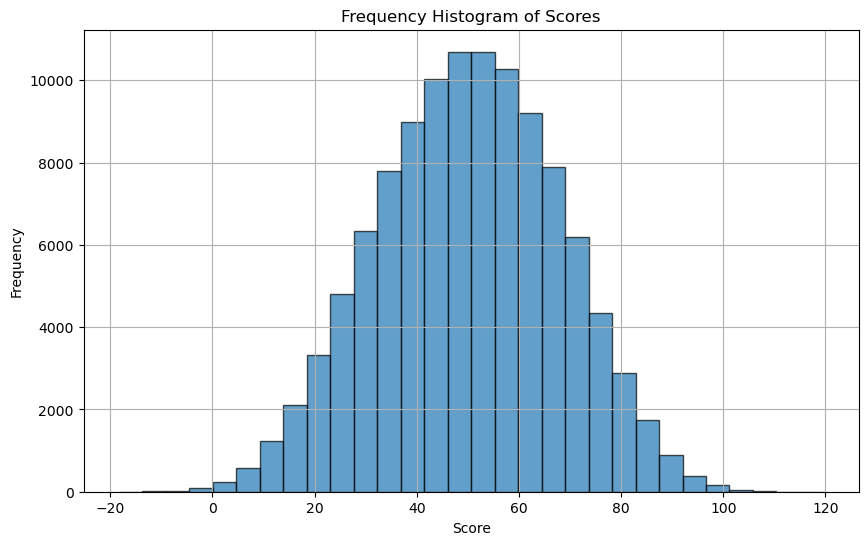

In [ ]:
# Read train data
df = pd.read_csv('image_download_segmentation/training_features_score.csv')

# Draw histogram
plt.figure(figsize=(10, 6))
plt.hist(df['score'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Frequency Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [ ]:
# Split features and label
X = data.iloc[:, 3:-2]  # Select id1 to id50 as independent variables
y = data.iloc[:, -1]    # Select score as dependent variable


# use 20% samples to tune hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [ ]:
# define intial parameter distribution
param_distributions = {
    'num_leaves': np.arange(100, 300, 10),
    'learning_rate': np.linspace(0.001, 0.01, 10),
    'n_estimators': np.arange(1000, 2000, 100),
    'max_depth': np.arange(20, 40, 2),
    'min_child_samples': np.arange(10, 30, 2),
    'subsample': np.linspace(0.7, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 0.8, 10)
}

# creat LightGBM regressor
model = lgb.LGBMRegressor()

# use random grid search to optimise parameter
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=150,  # iteration number
    cv=5,  # CV folders
    verbose=1,
    n_jobs=-1,
    scoring='r2',
    random_state=77
)

# searching
random_search.fit(X_train, y_train)

# 输出最佳参数和得分 output best parameter and score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

In [ ]:
# define finer parameter ranges based on previous search result
param_distributions = {
    'num_leaves': (180, 200),
    'learning_rate': (0.004, 0.006),
    'n_estimators': (1400, 1500),
    'max_depth': (28, 32),
    'min_child_samples': (18, 22),
    'subsample': (0.85, 0.9),
    'colsample_bytree': (0.6, 0.65)
}

# creat LightGBM regressor
model = lgb.LGBMRegressor()

# use bayesian optimization to tune parameter
bayes_search = BayesSearchCV(
    model,
    search_spaces=param_distributions,
    n_iter=100,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='r2',
    random_state=77
)

# start searching
bayes_search.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters found: ", bayes_search.best_params_)
print("Best score: ", bayes_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
# Use best parameter to train the predictive model

# best_params = bayes_search.best_params_

# final_model = lgb.LGBMRegressor(**best_params, n_jobs=-1)

best_params = {
    'colsample_bytree': 0.6253360032008146,
    'learning_rate': 0.005265857511077068,
    'max_depth': 30,
    'min_child_samples': 22,
    'n_estimators': 1435,
    'num_leaves': 187,
    'subsample': 0.8829892788011161,
    'n_jobs': -1
}

final_model = lgb.LGBMRegressor(**best_params)

final_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7302
[LightGBM] [Info] Number of data points in the train set: 88790, number of used features: 43
[LightGBM] [Info] Start training from score 50.076123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.6253360032008146,
              learning_rate=0.005265857511077068, max_depth=30,
              min_child_samples=22, n_estimators=1435, n_jobs=-1,
              num_leaves=187, subsample=0.8829892788011161)

In [ ]:
print("R2 on the training data:")
print(final_model.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(final_model.score(X=X_test, y=y_test))

R2 on the training data:
0.4379870950271372
R2 on the testing data:
0.31558029967145407


In [ ]:
print("RMSE on the training data:")
print(mean_squared_error(y_train, final_model.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, final_model.predict(X_test), squared=False))

RMSE on the training data:


F:\ANACONDA\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


13.371580009895116
RMSE on the testing data:
14.778219509864613


F:\ANACONDA\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


We have also applied XGBoost model, and the process is quite similar, so we replace it and only keep the LGBoost model, as the LGBoost perform a bit better and been chosen as the final model.

The random forest model process is as follows.

In [ ]:
# Define RF
rf_model = RandomForestClassifier(random_state=77)

# Define range of parameters
param_distributions = {
    'n_estimators': [100, 200, 400, 500, 600, 800],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [35, 40, 45, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 10],
    'bootstrap': [True, False]
}

# Use random research and CV to tune parameters
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=777
)

# Start searching
random_search.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (random_search.best_params_)
print ("The best score is: ")
print (random_search.best_score_)

# The best parameter value is:
# {'max_depth': 20, 'min_samples_split': 4}
# The best score is:
# 0.47858582553172296

In [ ]:
# use best parameters to train model
best_params = random_search.best_params_
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=6,
                       min_samples_split=15, n_estimators=600, random_state=42)

In [ ]:
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy:{accuracy_score(y_test, y_pred)}')

In [ ]:
print("R2 on the training data:")
print(final_model.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(final_model.score(X=X_test, y=y_test))

# R2 on the training data:0.6946769263145357
# R2 on the testing data:0.30817747524273353

In [ ]:
print("RMSE on the training data:")
print(mean_squared_error(y_train, final_model.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, final_model.predict(X_test), squared=False))

# RMSE on the training data:9.854970521685795
# RMSE on the testing data:14.854589421912005

The R² of 0.63 and RMSE of 0.874 reflect moderate predictive performance. High R² values can signal overfitting, leading to reduced generalization capabilities (James et al., 2013). Given the qualitative nature of streetscape quality assessments and their susceptibility to cognitive biases (Kahneman & Tversky, 1979), the observed R² and RMSE are expected. The model's performance is adequate for basic predictions of streetscape quality.

   Feature  Importance
1      id2    0.095662
6      id7    0.091461
2      id3    0.088587
4      id5    0.082726
11    id12    0.077574
0      id1    0.070158
32    id33    0.067164
9     id10    0.059752
17    id18    0.057646
13    id14    0.055106
43    id44    0.037839
12    id13    0.031525
25    id26    0.024956
16    id17    0.020928
38    id39    0.020040
3      id4    0.018717
29    id30    0.016274
21    id22    0.013745
14    id15    0.012152
34    id35    0.009885
26    id27    0.009559
5      id6    0.008742
40    id41    0.008004
42    id43    0.005437
8      id9    0.004527
46    id47    0.001825
15    id16    0.001686
10    id11    0.001615
19    id20    0.001611
48    id49    0.001585
18    id19    0.000588
7      id8    0.000528
28    id29    0.000502
24    id25    0.000453
22    id23    0.000382
45    id46    0.000337
31    id32    0.000217
36    id37    0.000206
30    id31    0.000180
23    id24    0.000090
33    id34    0.000011
27    id28    0.000011
37    id38 

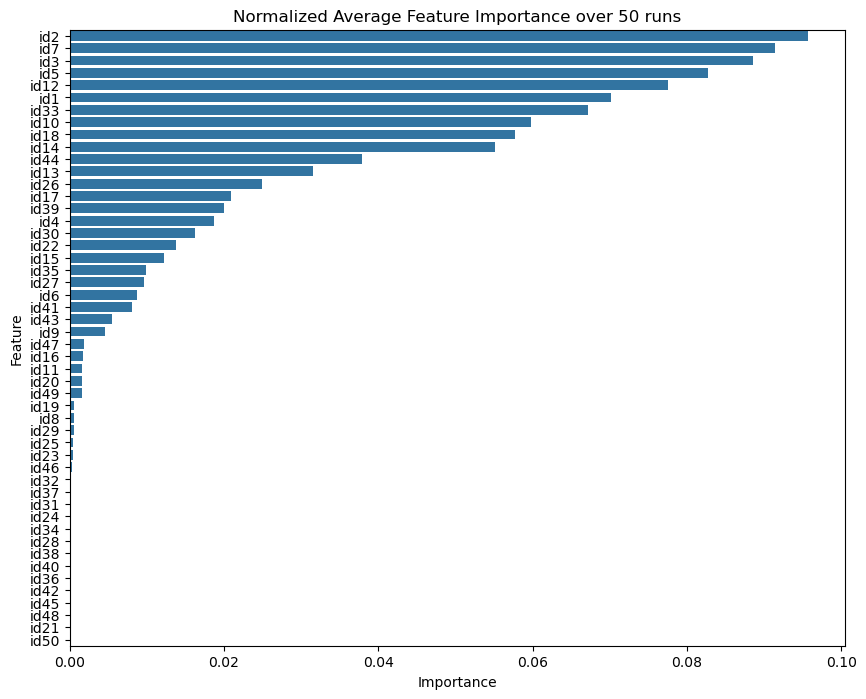

In [ ]:
# Output feature importance (FI) of LGBoost model. Calculate 50 average value
# Set loop iteration
n_runs = 50

# Get feature names
feature_names = X_train.columns

# initialise accumulated array of FI
feature_importances = np.zeros(len(feature_names))

for i in range(n_runs):
    # get current FI
    imp = final_model.feature_importances_

    # accumulate FI in 50 loops
    feature_importances += imp

# Calculate anverage FI
feature_importances /= n_runs

# create DataFrame then visulise
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Standerdise FI to 0-1
feature_importances_df['Importance'] /= feature_importances_df['Importance'].sum()

#  Descending FI
feature_importances_sorted = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_sorted)

# Visulisation
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_sorted)
plt.title('Normalized Average Feature Importance over 50 runs')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# # Save the trained model. The model file has already provided.

folder = 'save_model'
if not os.path.exists(folder):
    os.mkdir('pred/save_model')
joblib.dump(final_model, "pred/save_model/model.m")

['pred/save_model/model.m']

### 1.4 Predict Perceived Quality Score in London CAZ

In [ ]:
save_path = 'pred/predict_result_CAZ.csv'

# import the segmented result
ds = pd.read_csv('image_download_segmentation/semantic_segmentation/segmentation_result_CAZ.csv')
X = ds.iloc[:, 1:51]
ids = ds.iloc[:, 0]

# load the trained LGBoost model
regressor = joblib.load("pred/save_model/model.m")

# process prediction
predict_result = regressor.predict(X)

# record prediction result into csv
with codecs.open(save_path, 'w', 'utf_8_sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'Prediction'])  # write table head
    for id_val, prediction in zip(ids, predict_result):
        writer.writerow([id_val, prediction])

print('[-]Prediction done!')

[-]Prediction done!


In [ ]:
# Get the final perceived streetscape quality scores by joining the prediction result with the segmentation result csv.
# import the 2 files
df1 = pd.read_csv('image_download_segmentation/semantic_segmentation/segmentation_result_CAZ.csv')
df2 = pd.read_csv(save_path)

# added headers for prediction result df2
df2.columns = ['id', 'Prediction']

# join them by 'id', which is the index of images
merged_df = pd.merge(df1, df2, on='id')
# rename header
merged_df.rename(columns={'id': 'FID'}, inplace=True)

merged_df.to_csv('pred/predict_result_joined_CAZ.csv', index=False)

# Print prediction results
print(merged_df.head())

        FID       id1       id2       id3       id4       id5  id6       id7  \
0   1_0.jpg  0.045967  0.141389  0.000722  0.000000  0.382996  0.0  0.071341   
1   1_1.jpg  0.016256  0.331815  0.158433  0.000000  0.062281  0.0  0.200541   
2   1_2.jpg  0.087204  0.453204  0.083963  0.000000  0.083544  0.0  0.091381   
3   1_3.jpg  0.024652  0.063107  0.351130  0.001204  0.122963  0.0  0.167915   
4  10_0.jpg  0.080333  0.054078  0.111789  0.000000  0.293852  0.0  0.295381   

   id8  id9  ...  id42  id43      id44  id45  id46  id47  id48  id49  id50  \
0  0.0  0.0  ...     0   0.0  0.000000   0.0   0.0   0.0     0   0.0   0.0   
1  0.0  0.0  ...     0   0.0  0.000000   0.0   0.0   0.0     0   0.0   0.0   
2  0.0  0.0  ...     0   0.0  0.000000   0.0   0.0   0.0     0   0.0   0.0   
3  0.0  0.0  ...     0   0.0  0.000015   0.0   0.0   0.0     0   0.0   0.0   
4  0.0  0.0  ...     0   0.0  0.000000   0.0   0.0   0.0     0   0.0   0.0   

   Prediction  
0   58.833439  
1   55.159158  
2 

In [ ]:
# Calculate the final score of each street-view point by calculate the average score of 4 images of each point

df = pd.read_csv('pred/predict_result_joined_CAZ.csv')

# Calculate the final score by each FID
df['Fid'] = df['FID'].apply(lambda x: int(x.split('_')[0]))

summary_df = df.groupby('Fid')['Prediction'].agg(['mean']).reset_index()

summary_df.columns = ['FID', 'score']

# Join lat and lng columns
loc = pd.read_csv('pred/CAZ_points.csv')

merged_id_loc = pd.merge(summary_df, loc, left_on='FID', right_on='FID', how='left')

# merged_id_loc.drop(columns=['_id'], inplace=True)

# move 'lat' and 'lng' to second and third place
merged_id_loc.insert(1, 'lat', merged_id_loc.pop('lat'))

merged_id_loc.insert(2, 'lng', merged_id_loc.pop('lng'))

# save csv
merged_id_loc.to_csv('pred/CAZ_quality_score.csv', index=False)

merged_id_loc

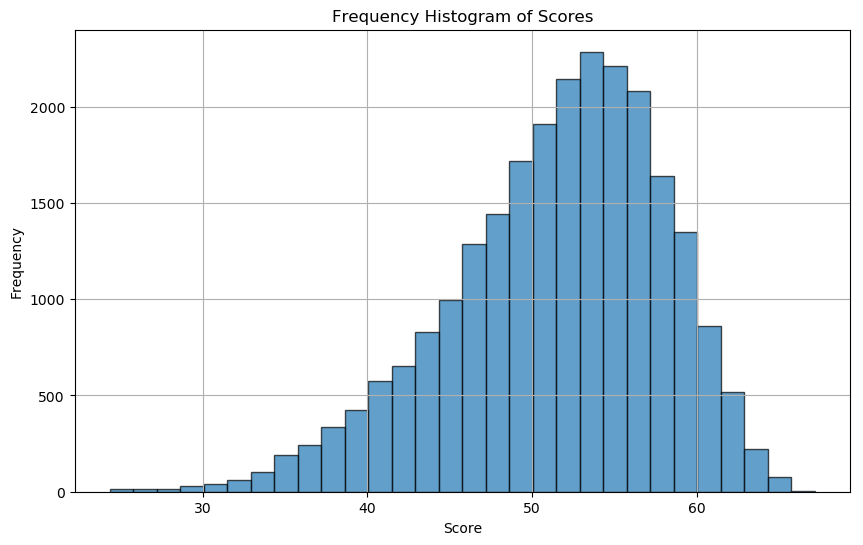

In [ ]:
# check the final perceived score by drawing histogram

score = pd.read_csv('pred/CAZ_quality_score.csv')

plt.figure(figsize=(10, 6))
plt.hist(score['score'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Frequency Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

In [5]:
df = pd.read_csv('pred/CAZ_quality_score.csv')
df

FID        lat       lng      score
0      13767  51.504356 -0.118838  71.737617
1      13769  51.504431 -0.118706  71.737617
2      12884  51.506668 -0.182781  70.490716
3      13548  51.504625 -0.168659  69.044428
4      12886  51.505739 -0.181701  68.999963
...      ...        ...       ...        ...
19595  18184  51.495093 -0.116156  25.759310
19596  13368  51.504688 -0.082579  25.724663
19597  10011  51.511397 -0.142856  25.558263
19598  16355  51.498149 -0.114507  25.352989
19599  10281  51.511251 -0.100584  25.108097

[19600 rows x 4 columns]

For the prediction of buffer zone is basically the same to CAZ, so we skip it. The final csv of buffer zone prediction is "bufferzone_quality_score.csv".

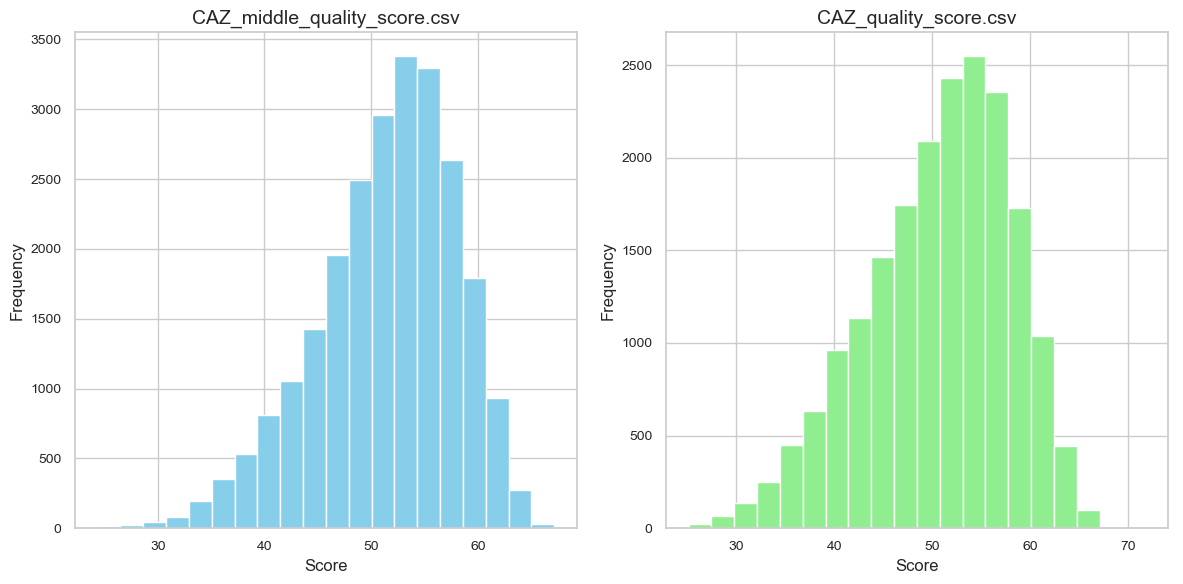

In [43]:
# Check the prediction of perceived quality score of 2 areas.

df_bufferzone = pd.read_csv('pred/bufferzone_quality_score.csv')
df_CAZ = pd.read_csv('pred/CAZ_quality_score.csv')

plt.figure(figsize=(12, 6))

# draw histogram of buffer zone score "CAZ_middle_quality_score.csv"
plt.subplot(1, 2, 1)
plt.hist(df_bufferzone['score'], bins=20, color='skyblue')
plt.title('bufferzone_quality_score.csv', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# draw histogram of CAZ "CAZ_quality_score.csv"
plt.subplot(1, 2, 2)
plt.hist(df_CAZ['score'], bins=20, color='lightgreen')
plt.title('CAZ_quality_score.csv', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

plt.tight_layout()

# Save to png
plt.savefig('histograms.png')

plt.show()


Some street-view images may deviate to indoors. In order to avoid predict error, we mannually deleted indoor images, and replace their perceived quality score with a neighbour's.

In [ ]:
# Join the quality score with original street-view points csv
file1 = 'LondonCAZ/CAZ_points.csv'
file2 = 'LondonCAZ/CAZ_quality_score.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

merged_df = pd.merge(df1, df2[['FID', 'score']], on='FID', how='left')

# print info, as we can see there are about 1000 points with no scores.
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25243 entries, 0 to 25242
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FID     25243 non-null  int64  
 1   lng     25243 non-null  float64
 2   lat     25243 non-null  float64
 3   score   24280 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 789.0 KB


In [ ]:
# the function to fill NaN with it's neighbours
def fill_na_with_neighbors(series):
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            prev_score = series.iloc[i-1] if i > 0 else None
            next_score = series.iloc[i+1] if i < len(series) - 1 else None

            if pd.notna(prev_score) and pd.notna(next_score):
                series.iloc[i] = (prev_score + next_score) / 2
            elif pd.notna(prev_score):
                series.iloc[i] = prev_score
            elif pd.notna(next_score):
                series.iloc[i] = next_score

    return series


merged_df['score'] = fill_na_with_neighbors(merged_df['score'])


In [ ]:
# check the result
merged_df['score'] = round(merged_df['score'])

merged_df.to_csv('pred/CAZ_quality_score_all.csv', index=False)

merged_df.head(20)

FID       lng        lat  score
0     0 -0.182933  51.549144   53.0
1     1 -0.183315  51.549567   53.0
2     2 -0.181220  51.548840   47.0
3     3 -0.180530  51.548833   37.0
4     4 -0.181458  51.549333   58.0
5     5 -0.181379  51.549524   55.0
6     6 -0.180939  51.549704   60.0
7     7 -0.179134  51.549406   58.0
8     8 -0.177685  51.548029   55.0
9     9 -0.177666  51.549363   58.0
10   10 -0.177685  51.549646   53.0
11   11 -0.176704  51.549343   52.0
12   12 -0.178577  51.549079   50.0
13   13 -0.175817  51.547924   64.0
14   14 -0.175119  51.549581   54.0
15   15 -0.172313  51.548853   39.0
16   16 -0.173206  51.548654   37.0
17   17 -0.172904  51.549102   40.0
18   18 -0.172230  51.549087   45.0
19   19 -0.172523  51.549465   50.0

In [9]:
# Output mean, median, std of predicted perceived quality in London CAZ

df_mid = pd.read_csv('pred/bufferzone_quality_score.csv')
df_caz = pd.read_csv('pred/CAZ_quality_score.csv')


mid_mean_score = df_mid['score'].mean()
mid_median_score = df_mid['score'].median()
mid_sd_score = df_mid['score'].std()
caz_mean_score = df_caz['score'].mean()
caz_median_score = df_caz['score'].median()
caz_sd_score = df_caz['score'].std()
    
# print
print(f"mid_mean_Score: {mid_mean_score:.2f}")
print(f"mid_Median Score: {mid_median_score:.2f}")
print(f"mid_Standard Deviation Score: {mid_sd_score:.2f}")
print("---")
print(f"caz_mean_score: {caz_mean_score:.2f}")
print(f"caz_Median Score: {caz_median_score:.2f}")
print(f"caz_Standard Deviation Score: {caz_sd_score:.2f}")
print("---")

mid_mean_Score: 51.44
mid_Median Score: 52.32
mid_Standard Deviation Score: 6.54
---
caz_mean_score: 50.63
caz_Median Score: 51.61
caz_Standard Deviation Score: 7.39
---


So the same with buffer zone's scores. We don't demonstrate here.

## 2. Processing POI

In [ ]:
# Here, we have already mannually filter particular POI classifications according to our research purpose. Saved as 'CAZ_poi.csv'.

poi = pd.read_csv('POI/CAZ_poi.csv', encoding='latin1')

# Check how many classifications left
column_name = 'fclass'
unique_values = poi[column_name].unique()

print(len(unique_values.tolist()))

89


In [ ]:
# Here, we have already mannualy calculate the weight for each POI category based on share of travel purpose (TFL, 2011)
# Save as 'poi_classification.csv'
# Next we are going to standerdise the weight to 0-1
df = pd.read_csv('poi_classification.csv', encoding='latin1')

min_max_scaler = MinMaxScaler()

df['Normalized_Weight'] = min_max_scaler.fit_transform(df[['Weight']])

# save csv
df.to_csv('POI/Std_poi_clasfct.csv', index=False)

## 3. Calculate Human-Scale Accessibility (HSA)

In [ ]:
import geopandas as gpd
import networkx as nx
import shapely.wkt
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPoint
from shapely import ops
from shapely.ops import linemerge, nearest_points, split
from shapely.prepared import prep
from collections import defaultdict
import pandas as pd
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import csv
from math import sqrt

from shapely.ops import transform
from pyproj import Transformer
from rtree import index
import multiprocessing as mp
import numba
# import cugraph
# import cudf
# import cuspatial

from numba import cuda, float32
import concurrent.futures
import rtree
import itertools

Here, we have already process the vector and csv data in ArcGIS. We got the roadline shapefile with perceived quality score for each street, and POI shapefile with POI weight. We then use Networkx to calculate HSA.

In [ ]:
# read roadline network
road_network = gpd.read_file('HSA/Research_Area_roadline_wgs1984.shp')

# create MultiGraph object
G = nx.MultiGraph()

# Transformer of wgs1984 to UTM. So using UTM to calculate the distance by meter unit in later steps.
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32630", always_xy=True)

def transform_geometry(geometry):
    return transform(transformer.transform, geometry)

# Print columns names of roadline network
print(road_network.columns)

Index(['Join_Count', 'ORIG_FID', 'lng', 'lat', 'score_perc', 'FID_0', 'length',
       'geometry'],
      dtype='object')


In [ ]:
# It processes each polyline in the road network, converts the coordinates to UTM projection,
# and adds nodes and edges to the graph with attributes such as FID, score_perc, and length.

# Create a counter for node IDs
node_id = 0

# Create a dictionary to store the mapping from coordinates to node IDs
coord_to_node = {}

# Create a counter for edge IDs
edge_id = 0

# Add each polyline as an edge to the graph
for _, row in road_network.iterrows():
    fid = row['FID_0']
    score_perc = row['score_perc']
    geometry = row.geometry

    # Convert WGS1984 coordinates to UTM projection coordinates
    utm_geometry = transform_geometry(geometry)
    
    if isinstance(utm_geometry, shapely.geometry.LineString):
        # Convert the transformed LineString to a list of points
        points = list(utm_geometry.coords)
    
        # Check if the start node already exists
        start_coord = points[0]
        if start_coord in coord_to_node:
            node_start_id = coord_to_node[start_coord]
        else:
            node_start_id = node_id
            coord_to_node[start_coord] = node_start_id
            node_id += 1
            G.add_node(node_start_id, FID=fid, score_perc=score_perc, coord=start_coord)
    
        # Check if the end node already exists
        end_coord = points[-1]
        if end_coord in coord_to_node:
            node_end_id = coord_to_node[end_coord]
        else:
            node_end_id = node_id
            coord_to_node[end_coord] = node_end_id
            node_id += 1
            G.add_node(node_end_id, FID=fid, score_perc=score_perc, coord=end_coord)
    
        # Calculate the length of the edge (in meters)
        length = utm_geometry.length
    
        # Assign a unique identifier to each edge
        edge_key = edge_id
        edge_id += 1
    
        # Add the polyline as an edge with FID_0, score_perc, and length as edge attributes
        G.add_edge(node_start_id, node_end_id, key=edge_key, FID=fid, score_perc=score_perc, geometry=utm_geometry, length=length)
    
    elif isinstance(utm_geometry, shapely.geometry.MultiLineString):
        for line in utm_geometry.geoms:
            # Convert the transformed LineString to a list of points
            points = list(line.coords)
    
            # Check if the start node already exists
            start_coord = points[0]
            if start_coord in coord_to_node:
                node_start_id = coord_to_node[start_coord]
            else:
                node_start_id = node_id
                coord_to_node[start_coord] = node_start_id
                node_id += 1
                G.add_node(node_start_id, FID=fid, score_perc=score_perc, coord=start_coord)
    
            # Check if the end node already exists
            end_coord = points[-1]
            if end_coord in coord_to_node:
                node_end_id = coord_to_node[end_coord]
            else:
                node_end_id = node_id
                coord_to_node[end_coord] = node_end_id
                node_id += 1
                G.add_node(node_end_id, FID=fid, score_perc=score_perc, coord=end_coord)
    
            # Calculate the length of the edge (in meters)
            length = line.length
    
            # Assign a unique identifier to each edge
            edge_key = edge_id
            edge_id += 1
    
            # Add the polyline as an edge with FID_0, score_perc, and length as edge attributes
            G.add_edge(node_start_id, node_end_id, key=edge_key, FID=fid, score_perc=score_perc, geometry=line, length=length)
    
    else:
        raise ValueError(f"Unsupported geometry type: {type(utm_geometry)}")

# Print the number of nodes and edges in the graph
print("Number of nodes in graph:", G.number_of_nodes())
print("Number of edges in graph:", G.number_of_edges())

Number of nodes in graph: 34523
Number of edges in graph: 44695


In [ ]:
# check if all edges have been added to G
# print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# # Check FID of each edge
# for u, v, attr in G.edges(data=True):
#     print(f"Edge: {u} -> {v}, FID: {attr['FID_0']}")

# Check missing FID
shp_fids = set(road_network['FID_0'])

graph_fids = set([attr['FID'] for _, _, attr in G.edges(data=True)])

missing_fids = shp_fids - graph_fids

# print missing FID
if missing_fids:
    print("Missing FIDs:")
    for fid in missing_fids:
        print(fid)
else:
    print("No missing FIDs.")

Number of edges: 44695
No missing FIDs.


In [ ]:
# Check features of first 20 edges
print("\nSample edges:")
for i, edge in enumerate(G.edges(data=True)):
    if i < 20:
        print(edge)


Sample edges:
(0, 1, {'FID': 0, 'score_perc': 0.54, 'geometry': <LINESTRING (699648.478 5713925.38, 699631.411 5713914.483, 699620.55 571390...>, 'length': 95.3754863917385})
(1, 28, {'FID': 27, 'score_perc': 0.49, 'geometry': <LINESTRING (699613.814 5713850.686, 699618.31 5713835.047)>, 'length': 16.272451293678824})
(2, 3, {'FID': 1, 'score_perc': 0.46, 'geometry': <LINESTRING (699277.923 5713779.008, 699262.303 5713770.318, 699218.663 5713...>, 'length': 181.7904000549609})
(2, 4, {'FID': 2, 'score_perc': 0.43, 'geometry': <LINESTRING (699285.02 5713781.96, 699277.923 5713779.008)>, 'length': 7.686100551485434})
(4, 7, {'FID': 4, 'score_perc': 0.47, 'geometry': <LINESTRING (699285.02 5713781.96, 699317.235 5713794.871, 699336.085 571380...>, 'length': 56.344064431838504})
(5, 6, {'FID': 3, 'score_perc': 0.43, 'geometry': <LINESTRING (699273.31 5713803.209, 699267.66 5713798.85)>, 'length': 7.136246773052649})
(5, 8, {'FID': 5, 'score_perc': 0.43, 'geometry': <LINESTRING (699275.91 

In [ ]:
# Check connected components
num_components = nx.number_connected_components(G)

print(f'Graph G has {num_components} connected components.')

# As London 40000 more complex road network, so 365 connected components is relatively reasonable

Graph G has 365 connected components.


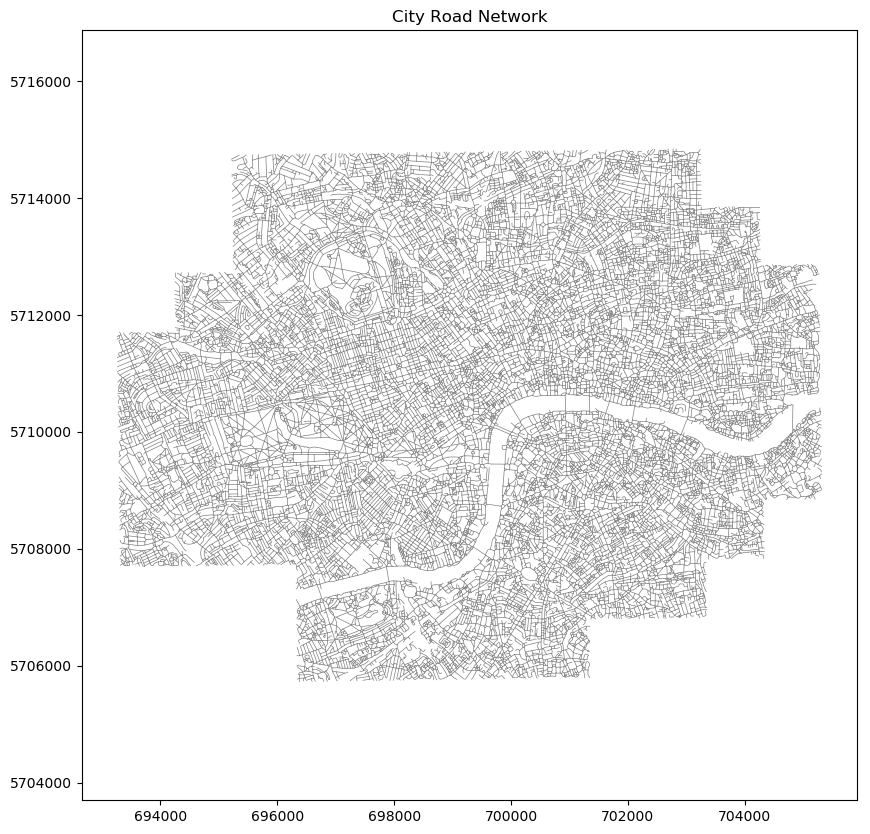

In [ ]:
# Draw the road network map

plt.figure(figsize=(10, 10))

for u, v, data in G.edges(data=True):
    geometry = data['geometry']
    xs, ys = geometry.xy
    plt.plot(xs, ys, color='gray', linewidth=0.5)

plt.title('City Road Network')
plt.axis('equal')
plt.show()

It's a time travel. We have tried calculating HSA in later process and back to here. We found it's a very time-consuming work by using directly the network distance (31000 hr). So we decide to use circuity factor to calculate newtwork distance by multiply with Euclidean distance.

In [ ]:
import random
from shapely.geometry import Point, LineString

def calculate_distance_factor(G, max_euclidean_dist=1000, num_samples=5000):
    # Get all edges in the graph
    edges = list(G.edges(keys=True, data=True))

    euclidean_distances = []
    network_distances = []

    while len(network_distances) < num_samples:
        # Randomly select an edge
        u, v, _, edge_data = random.choice(edges)
        edge_geometry = edge_data['geometry']

        # Get endpoint coordinates from the edge's geometry
        start_coord = edge_geometry.coords[0]
        end_coord = edge_geometry.coords[-1]

        # Randomly select one of the edge's endpoints as the starting point
        start_node = random.choice([u, v])
        start_point = Point(start_coord if start_node == u else end_coord)

        # Randomly select a node different from the starting point as the target point,
        # and ensure the Euclidean distance is within the specified range
        target_nodes = [node for node in G.nodes() if node != start_node]
        random.shuffle(target_nodes)
        target_node = None
        for node in target_nodes:
            target_edges = [edge for edge in edges if node in edge[:2]]
            if not target_edges:
                continue
            target_edge = random.choice(target_edges)
            target_edge_geometry = target_edge[-1]['geometry']
            target_coord = target_edge_geometry.coords[0] if node == target_edge[0] else target_edge_geometry.coords[-1]
            target_point = Point(target_coord)

            # Calculate the Euclidean distance
            euclidean_dist = start_point.distance(target_point)

            if 0 < euclidean_dist <= max_euclidean_dist:
                target_node = node
                break

        if target_node is None:
            continue

        euclidean_distances.append(euclidean_dist)

        # Calculate the network distance
        try:
            network_dist = nx.shortest_path_length(G, source=start_node, target=target_node, weight='length')
            network_distances.append(network_dist)
        except nx.NetworkXNoPath:
            pass

    # Calculate the average distance factor
    if len(network_distances) > 0 and len(euclidean_distances) > 0:
        distance_factors = [network_dist / euclidean_dist for network_dist, euclidean_dist in zip(network_distances, euclidean_distances)]
        avg_distance_factor = sum(distance_factors) / len(distance_factors)
        return avg_distance_factor
    else:
        print("Unable to calculate the average distance factor: No valid network distance or Euclidean distance samples.")
        return None

# Assume G is the loaded MultiGraph object representing the urban road network of London
avg_distance_factor = calculate_distance_factor(G, max_euclidean_dist=1000, num_samples=10000)
if avg_distance_factor is not None:
    print(f"Circuity factor for the urban road network of London within a range of 1000 meters: {avg_distance_factor:.3f}")

# ircuity factor for the urban road network of London within a range of 1000 meters: 2.448

We have 2 shapefiles, remember? Then we are going to add the second shp into G. In Networkx, the POI polygons is stored as points. (For Networkx has only edges and points data type)

In [ ]:
# Similarly, the POI shp has already been processed in ArcGIS. We extend their boundaries by 15m, so they could intersect with roadlines.
# It's helpful to calculate the network distance then.

poi_polygons = gpd.read_file('HSA/London_POI_buffer_15_joined.shp')

print(poi_polygons.columns)

Index(['osm_id', 'code', 'fclass', 'name', 'Category', 'BUFF_DIST', 'ORIG_FID',
       'POI', 'Category_1', 'Weight', 'Normalized', 'geometry'],
      dtype='object')


In [ ]:
# Add POIs into G as points, transform the projection as well.
for _, row in poi_polygons.iterrows():
    orig_fid = row['ORIG_FID']
    normalized_weight = row['Normalized']
    fclass = row['fclass']
    geometry = row.geometry

    utm_geometry = transform_geometry(geometry)

    G.add_node(node_id, ORIG_FID=orig_fid, Normalized_Weight=normalized_weight, geometry=utm_geometry, fclass = fclass, poi=True)
    node_id += 1

# check the overall edges and points with the original number shown in ArcGIS.
# The edges number should be same with 'streets' lines. 
# And the nodes contain nodes of edges and POI polygons.
print("Number of nodes in graph:", G.number_of_nodes())
print("Number of edges in graph:", G.number_of_edges())

Number of nodes in graph: 50823
Number of edges in graph: 44695


In [ ]:
# Check the POI nodes numbers, it should be the same to the number shown in ArcGIS.

def count_poi_nodes(G):
    count = 0
    for node, poi_data in G.nodes(data=True):
        if 'poi' in poi_data:
            count += 1
    return count

num_poi_nodes = count_poi_nodes(G)
print(f"Number of POI nodes in the graph: {num_poi_nodes}")

Number of POI nodes in the graph: 16300


In [ ]:
# Check if any edges lack of FID.

missing_FID_edges = []
for u, v, key in G.edges(keys=True):
    if 'FID' not in G[u][v][key]:
        missing_FID_edges.append((u, v, key))

# 输出结果
if not missing_FID_edges:
    print("All Edges have FID。")
else:
    print("Following edges lack of FID:")
    for u, v, key in missing_FID_edges:
        print(f"Edge ({u}, {v}, {key}) lacks FID.")


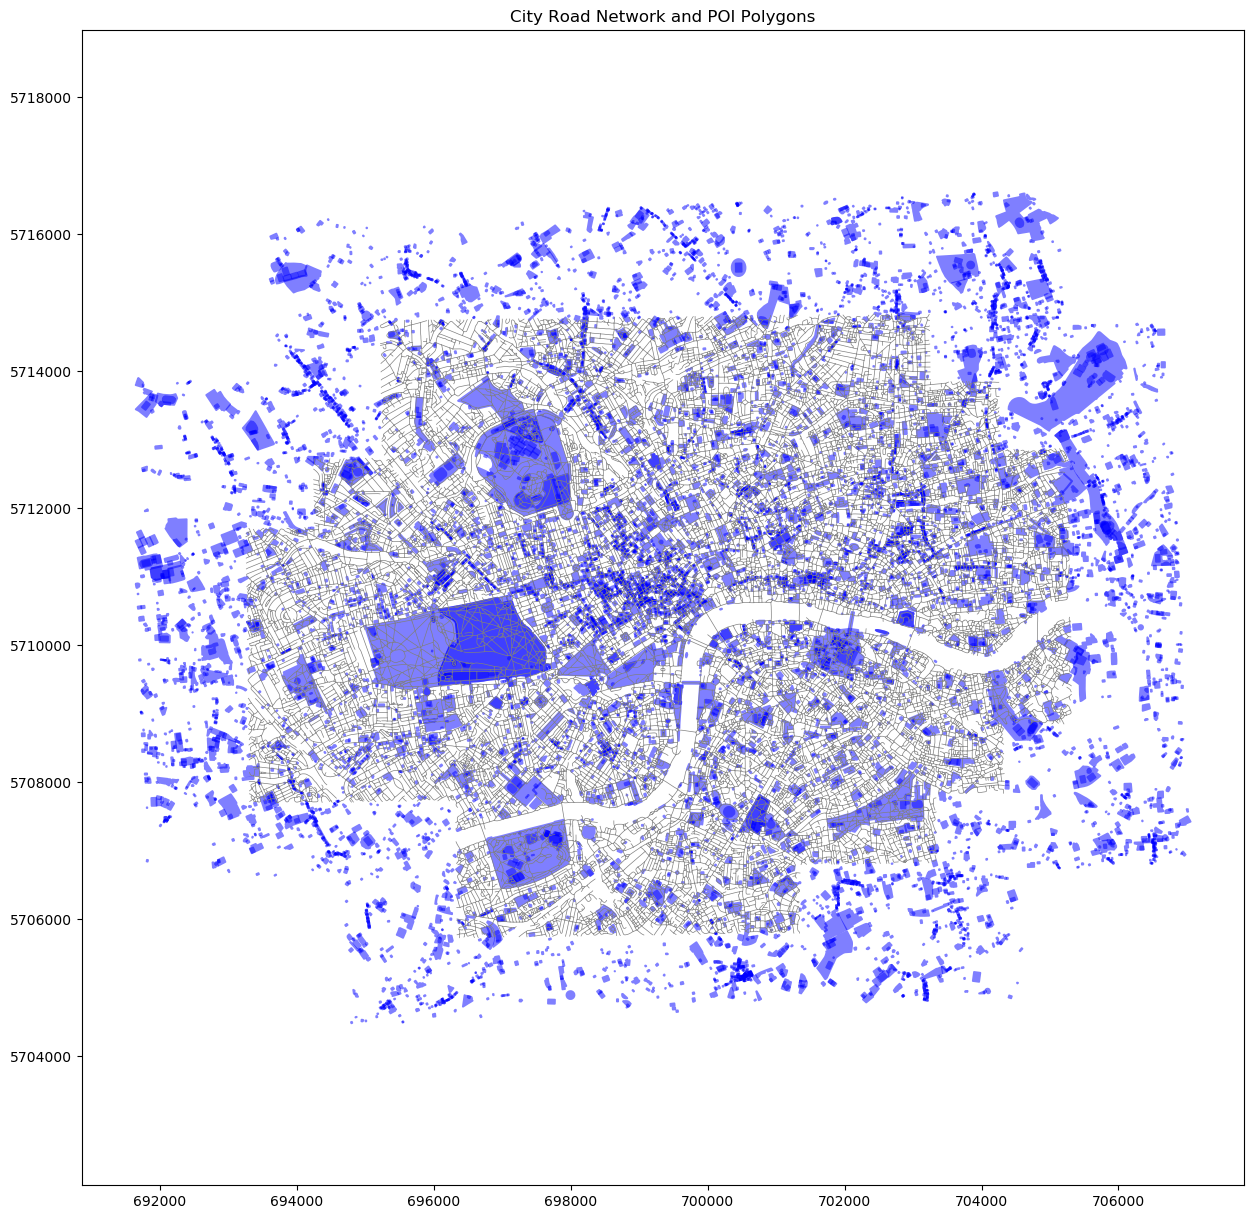

In [ ]:
# Draw the map of current G, it should be with road network and POIs

plt.figure(figsize=(15, 15))

# Draw road network
for u, v, data in G.edges(data=True):
    geometry = data['geometry']
    if isinstance(geometry, LineString):
        xs, ys = geometry.xy
        plt.plot(xs, ys, color='gray', linewidth=0.5)

# Draw POI polygons
for node, data in G.nodes(data=True):
    geometry = data.get('geometry')
    if isinstance(geometry, Polygon):
        xs, ys = geometry.exterior.xy
        plt.fill(xs, ys, alpha=0.5, fc='blue', ec='none')

plt.title('City Road Network and POI Polygons')
plt.axis('equal')
plt.show()

### 3.1 The original plan: Calculate HSA by network distance and the average perceived quality along the way on streets to POIs

#### Attention!!! 

As we discussed before, at first we planned to calculate the network distance for each street towards each POIs within its catchment, but it will take so much time (31000 hr). Though it is not a suitable plan for this study, but it is certainly a best way to calculate HSA if you can resolve calculation capacity problems. We are going to demonstrate the process first. Below is the process for the original plan. 

In [ ]:
# For calculating the pathway of streets to POIs, we need to get the intersected points of POIs with road network. 
# So we firstly calculate the intersections (Points) for each POIs, and store the intersections' coordinate to corresponding POIs
# It's not so easy as it looks, as the Networkx only identify nodes when calculate network distance, we need to cut each intercested line by intercestions
# by adding many new lines to replace original ones.

def precompute_poi_boundary_intersections(G):
    # Create a spatial index for the road network edges
    edge_index = index.Index()
    for u, v, key, data in G.edges(keys=True, data=True):
        edge_geometry = data['geometry']
        edge_bounds = edge_geometry.bounds
        edge_index.insert(hash((u, v, key)), edge_bounds, obj=(u, v, key, data))

    new_nodes = []
    new_edges = []
    edges_to_remove = []

    # Precompute the intersections between all POI polygon boundaries and the road network
    for node, poi_data in G.nodes(data=True):
        if 'poi' in poi_data:
            poi_geometry = poi_data.get('geometry')
            if isinstance(poi_geometry, Polygon):
                poi_boundary = poi_geometry.boundary
                intersections = []

                # Use the spatial index to query the road network edges that intersect with the POI boundary
                for item in edge_index.intersection(poi_boundary.bounds, objects=True):
                    u, v, key, data = item.object
                    edge_geometry = data['geometry']
                    intersection = edge_geometry.intersection(poi_boundary)
                    if not intersection.is_empty:
                        # Generate a unique node ID for the intersection point
                        intersection_node_id = f"poi_{node}_intersection_{len(intersections)}"

                        # Add the intersection point as a new node to the temporary list, mark it as an intersection node,
                        # and mark the POI polygon boundary it belongs to
                        new_nodes.append((intersection_node_id, {'geometry': intersection, 'type': 'poi_intersection', 'is_intersection': True, 'poi_orig_fid': poi_data['ORIG_FID']}))

                        # Split the line into two parts
                        split_result = split(edge_geometry, intersection)

                        # Extract a single point from MultiPoint
                        if isinstance(intersection, MultiPoint):
                            intersection = intersection.geoms[0]

                        # Mark the original edge for removal
                        edges_to_remove.append((u, v, key))

                        # Create new edges after splitting
                        edge_data1 = data.copy()
                        edge_data1['geometry'] = LineString([Point(edge_geometry.coords[0]), intersection])
                        edge_data1['length'] = edge_data1['geometry'].length
                        new_edges.append((u, intersection_node_id, edge_data1))

                        edge_data2 = data.copy()
                        edge_data2['geometry'] = LineString([intersection, Point(edge_geometry.coords[-1])])
                        edge_data2['length'] = edge_data2['geometry'].length
                        new_edges.append((intersection_node_id, v, edge_data2))

                        # Add the intersection coordinates to the intersections list
                        intersections.append((intersection.x, intersection.y))

                poi_data['boundary_intersections'] = intersections

    # Remove the edges marked for removal from the graph
    for u, v, key in edges_to_remove:
        if G.has_edge(u, v, key):
            G.remove_edge(u, v, key)

    # Add the new nodes and edges to the graph
    G.add_nodes_from(new_nodes)
    for u, v, data in new_edges:
        G.add_edge(u, v, **data)

    return G

G = precompute_poi_boundary_intersections(G)

In [ ]:
# check nodes and edges.
print("Number of nodes in graph:", G.number_of_nodes())
print("Number of edges in graph:", G.number_of_edges())

Number of nodes in graph: 83148
Number of edges in graph: 92869


In [ ]:
# The added new lines (edges) should have same FID, we can simply check which roadlines intercet with POIs and the new edges.

from collections import defaultdict

def check_edges_with_same_fid(G, max_groups=200):
    fid_groups = defaultdict(list)

    # group by FID
    for u, v, data in G.edges(data=True):
        fid = data.get('FID')
        if fid is not None:
            fid_groups[fid].append((u, v, data))

    # output edges with same FID
    for i, (fid, edges) in enumerate(fid_groups.items()):
        if i >= max_groups:
            break

        print(f"Edges with FID {fid}:")
        for u, v, data in edges:
            print(f"  ({u}, {v}, {data})")
        print()

check_edges_with_same_fid(G, max_groups=200)

Edges with FID 0:
  (0, 1, {'FID': 0, 'score_perc': 0.54, 'geometry': <LINESTRING (699648.478 5713925.38, 699631.411 5713914.483, 699620.55 571390...>, 'length': 95.3754863917385})

Edges with FID 27:
  (1, 28, {'FID': 27, 'score_perc': 0.49, 'geometry': <LINESTRING (699613.814 5713850.686, 699618.31 5713835.047)>, 'length': 16.272451293678824})

Edges with FID 1:
  (2, 3, {'FID': 1, 'score_perc': 0.46, 'geometry': <LINESTRING (699277.923 5713779.008, 699262.303 5713770.318, 699218.663 5713...>, 'length': 181.7904000549609})

Edges with FID 2:
  (2, 4, {'FID': 2, 'score_perc': 0.43, 'geometry': <LINESTRING (699285.02 5713781.96, 699277.923 5713779.008)>, 'length': 7.686100551485434})

Edges with FID 4:
  (4, 7, {'FID': 4, 'score_perc': 0.47, 'geometry': <LINESTRING (699285.02 5713781.96, 699317.235 5713794.871, 699336.085 571380...>, 'length': 56.344064431838504})

Edges with FID 3:
  (5, 6, {'FID': 3, 'score_perc': 0.43, 'geometry': <LINESTRING (699273.31 5713803.209, 699267.66 571379

In [ ]:
# check the intercetions, POI ORIG_FID shows which POI polygon it belongs.

intersection_nodes = [(node, data) for node, data in G.nodes(data=True) if 'is_intersection' in data and data['is_intersection']]
print(len(intersection_nodes))
for node, data in intersection_nodes:
    print(f"Node: {node}")
    print(f"  Geometry: {data['geometry']}")
    print(f"  Type: {data['type']}")
    print(f"  Is Intersection: {data['is_intersection']}")
    print(f"  POI ORIG_FID: {data['poi_orig_fid']}")
    print()

In [26]:
import geopandas as gpd
import networkx as nx
import shapely.wkt
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPoint
from shapely import ops
from shapely.ops import linemerge, nearest_points, split
from shapely.prepared import prep
from collections import defaultdict
import pandas as pd
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import csv
from math import sqrt

from shapely.ops import transform
from pyproj import Transformer
from rtree import index
import multiprocessing as mp
import numba
# import cugraph
# import cudf
# import cuspatial

from numba import cuda, float32
import concurrent.futures
import rtree
import itertools

In [32]:
# It's a function could help us view the features of POI nodes.

def view_poi_attributes(G):
    for node, data in G.nodes(data=True):
        if 'poi' in data:
            print(f"POI node {node} attributes:")
            for attr, value in data.items():
                if attr == 'geometry':
                    print(f"  {attr}: {type(value)}")
                else:
                    print(f"  {attr}: {value}")
            print()

In [28]:
# Save the current G to local file

output_file = "HSA/G_RA.gpickle"
nx.write_gpickle(G, output_file)

In [ ]:
# reload the G and check POI nodes' features
G = nx.read_gpickle(output_file)
view_poi_attributes(G)

Then we start calculate HSA for each street. Attention, we first calculate the accessibility, which is the main gravity model part. It's the most difficult part, by working this out, the HSA can be easily calculated by multiply with WDI. First comes the original plan:

In [ ]:
# The original code directly calculates network paths, which is very time-consuming
def calculate_human_scale_accessibility_1(G):
    print("Starting to calculate human-scale accessibility...")

    # Identify all POI nodes and intersection nodes
    poi_nodes = set()
    intersection_nodes = {}
    for node, data in G.nodes(data=True):
        if 'poi' in data:
            poi_nodes.add(node)
            poi_orig_fid = data['ORIG_FID']
            if poi_orig_fid not in intersection_nodes:
                intersection_nodes[poi_orig_fid] = set()
        if 'is_intersection' in data and data['is_intersection']:
            poi_orig_fid = data['poi_orig_fid']
            if poi_orig_fid in intersection_nodes:
                intersection_nodes[poi_orig_fid].add(node)

    print(f"There are {len(poi_nodes)} POI nodes")
    print(f"There are {len(intersection_nodes)} POI nodes got intersection nodes on boundary")

    # Create a copy list of edges
    edges_copy = list(G.edges(keys=True, data=True))

    # Calculate accessibility of each street (edge)
    for u, v, key, data in edges_copy:
        print(f"Deal with street (edge) ({u}, {v}, {key})...")
        edge_geometry = data['geometry']
        edge_score_perc = data['score_perc']

        # Calculate midpoint and project on original street line
        midpoint = edge_geometry.interpolate(0.5, normalized=True)
        projected_midpoint = ops.nearest_points(midpoint, edge_geometry)[1]

        # Add midpoint into G
        midpoint_node = 'midpoint_{}_{}'.format(hash((u, v)), key)
        G.add_node(midpoint_node, geometry=projected_midpoint)

        # Calculate line between start and end points
        line_to_u = ops.substring(edge_geometry, 0, edge_geometry.project(projected_midpoint))
        line_to_v = ops.substring(edge_geometry, edge_geometry.project(projected_midpoint), edge_geometry.length)

        # Connect midpoint, and give same score_perc to new edges
        G.add_edge(u, midpoint_node, length=line_to_u.length, score_perc=edge_score_perc, geometry=line_to_u)
        G.add_edge(midpoint_node, v, length=line_to_v.length, score_perc=edge_score_perc, geometry=line_to_v)

        # Get all accessible POIs of street within 1000m network distance
        print("Calculate accessible POIs")
        accessible_pois = []
        for poi_node in poi_nodes:
            poi_data = G.nodes[poi_node]
            poi_geometry = poi_data['geometry']

            min_distance = float('inf')
            min_path = None
            min_avg_score = None

            for intersection_node in intersection_nodes[poi_data['ORIG_FID']]:
                try:
                    if nx.has_path(G, source=midpoint_node, target=intersection_node):
                        path_length = nx.shortest_path_length(G, source=midpoint_node, target=intersection_node, weight='length')
                        if path_length <= 1000:
                            path = nx.shortest_path(G, source=midpoint_node, target=intersection_node, weight='length')
                            path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
                            path_scores = []
                            for edge_u, edge_v in path_edges:
                                edge_data = G.get_edge_data(edge_u, edge_v)
                                edge_key = min(edge_data, key=lambda k: edge_data[k]['length'])  # Select the edge with the shortest length
                                path_scores.append(edge_data[edge_key]['score_perc'])
                            avg_score = sum(path_scores) / len(path_scores)

                            if path_length < min_distance:
                                min_distance = path_length/1000
                                min_path = path
                                min_avg_score = avg_score
                except nx.NetworkXNoPath:
                    continue

            if min_path is not None:
                print(f"min_distant:{min_distance}, min_avg_score:{min_avg_score}")
                accessible_pois.append((poi_data, min_distance, min_avg_score))

        print(f"Edge ({u}, {v}, {key}) Accessible POI number: {len(accessible_pois)}")

        # Calculate accessibility
        accessibility = 0
        for poi_data, distance, avg_score in accessible_pois:
            poi_weight = poi_data['Normalized_Weight']
            # Add all together
            accessibility += (avg_score * poi_weight) / (distance ** 1.78)

        print(f"Edge ({u}, {v}, {key}) Accessibility: {accessibility}")

        # Give the accessibility value to the edge in G
        G.edges[u, v, key]['accessibility'] = accessibility
        # Remove midpoint of street and the edges we added at beginning
        G.remove_nodes_from(midpoint_node)

    print("All Calculations done")
    return G

G0 = calculate_human_scale_accessibility_1(G)

开始计算人性化可达性...
There are 16300 POI nodes
There are 16300 POI nodes got intersection nodes on boundary
Deal with street (edgs) (0, 1, 0)...
Calculate accessible POIs
min_distant:0.7395718069118614, min_avg_score:0.51
min_distant:0.24798736965430296, min_avg_score:0.5122222222222221
min_distant:0.5589494614905018, min_avg_score:0.5083333333333334
min_distant:0.560658970223326, min_avg_score:0.5083333333333334
min_distant:0.7078196145191846, min_avg_score:0.50875
min_distant:0.985583964374695, min_avg_score:0.5065624999999999
min_distant:0.8008099963998493, min_avg_score:0.4895833333333333
min_distant:0.8103000133222968, min_avg_score:0.4796153846153848
min_distant:0.8031062335297136, min_avg_score:0.4796153846153848
min_distant:0.7221452657349506, min_avg_score:0.4922727272727274
min_distant:0.6673381156531469, min_avg_score:0.5147826086956523
min_distant:0.5315924990581361, min_avg_score:0.5031578947368424
min_distant:0.9732078044878074, min_avg_score:0.5112903225806452
min_distant:0.535

The original plan is very time-consuming, each street takes about 20 minutes, as we have 90000 more streets, it will take us to next year for getting the result. Then it comes to the optimised plan using circuity factors. It also has 2 version, the first is operate by CPU (75 hrs), the second is by GPU (21 hrs). So obviously the second GPU version is faster.

In [38]:
# Circuity factor version, using CPU

import time
from tqdm import tqdm

def calculate_human_scale_accessibility_2(G, distance_factor=2.4):
    start_time = time.time()
    print("Starting to calculate human-scale accessibility...")

    # Identify all POI nodes and intersection nodes
    poi_nodes = set()
    intersection_nodes = {}
    poi_geometries = {}
    for node, data in G.nodes(data=True):
        if 'poi' in data:
            poi_nodes.add(node)
            poi_orig_fid = data['ORIG_FID']
            poi_geometries[poi_orig_fid] = data['geometry']
            if poi_orig_fid not in intersection_nodes:
                intersection_nodes[poi_orig_fid] = set()
        if 'is_intersection' in data and data['is_intersection']:
            poi_orig_fid = data['poi_orig_fid']
            if poi_orig_fid in intersection_nodes:
                intersection_nodes[poi_orig_fid].add(node)

    print(f"There are {len(poi_nodes)} POI nodes")
    print(f"There are {len(intersection_nodes)} POI nodes got intersection nodes on boundary")

    # Calculate accessibility of each street (edge)
    total_edges = len(G.edges)
    with tqdm(total=total_edges, desc="Processing edges", unit="edge") as pbar:
        for u, v, key, data in G.edges(keys=True, data=True):
            print(f"Deal with street (edge) ({u}, {v}, {key})...")
            edge_geometry = data['geometry']

            # Calculate midpoint of the street
            midpoint = edge_geometry.interpolate(0.5, normalized=True)

            # Calculate average "score_perc" of all streets within 800m Euclidean distance
            nearby_edges = []
            for u_nearby, v_nearby, key_nearby, data_nearby in G.edges(keys=True, data=True):
                nearby_edge_geometry = data_nearby['geometry']
                if midpoint.distance(nearby_edge_geometry) <= 500:
                    nearby_edges.append((u_nearby, v_nearby, key_nearby, data_nearby))

            avg_score_perc = sum(data_nearby['score_perc'] for _, _, _, data_nearby in nearby_edges) / len(nearby_edges) if nearby_edges else 0

            # Get all accessible POIs of street within 800m Euclidean distance
            print("Calculate accessible POIs")
            accessible_pois = []
            for poi_orig_fid, poi_geometry in poi_geometries.items():
                poi_nodes_copy = poi_nodes.copy()
                if poi_geometry.contains(midpoint):
                    # If the midpoint of the street is inside the POI, set the network distance to 150
                    network_distance = 150
                    accessible_pois.append((G.nodes[poi_nodes_copy.pop()], network_distance, avg_score_perc))
                else:
                    min_distance = float('inf')
                    for intersection_node in intersection_nodes[poi_orig_fid]:
                        intersection_geometry = G.nodes[intersection_node]['geometry']
                        euclidean_distance = midpoint.distance(intersection_geometry)
                        if euclidean_distance <= 100:
                            # If the Euclidean distance from the midpoint of the street to the POI boundary is less than 100 meters, set the network distance to 150
                            min_distance = 150
                            break
                        elif euclidean_distance <= 500:
                            if euclidean_distance < min_distance:
                                min_distance = euclidean_distance

                    if min_distance < float('inf'):
                        if min_distance != 150:
                            network_distance = min_distance * distance_factor
                        else:
                            network_distance = 150
                        accessible_pois.append((G.nodes[poi_nodes_copy.pop()], network_distance, avg_score_perc))

            print(f"Edge ({u}, {v}, {key}) Accessible POI number: {len(accessible_pois)}")

            # Calculate accessibility
            accessibility = 0
            for poi_data, distance, avg_score in accessible_pois:
                poi_weight = poi_data['Normalized_Weight']
                # Add all together
                accessibility += ((avg_score * poi_weight) / (distance ** 1.78)) * 1000

            print(f"Edge ({u}, {v}, {key}) Accessibility: {accessibility}")

            # Give the accessibility value to the edge in G
            G.edges[u, v, key]['accessibility'] = accessibility

            pbar.update(1)

    end_time = time.time()
    execution_time = end_time - start_time
    avg_time_per_edge = execution_time / total_edges

    print(f"All Calculations done. Total execution time: {execution_time:.2f} seconds")
    print(f"Average calculation time per edge: {avg_time_per_edge:.2f} seconds")

    return G

G0 = calculate_human_scale_accessibility_2(G, 2.4)

Starting to calculate human-scale accessibility...
There are 16300 POI nodes
There are 16300 POI nodes got intersection nodes on boundary


Processing edges:   0%|                                                                    | 0/92869 [00:00<?, ?edge/s]

Deal with street (edge) (0, 1, 0)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 1/92869 [00:03<79:10:53,  3.07s/edge]

Edge (0, 1, 0) Accessible POI number: 84
Edge (0, 1, 0) Accessibility: 0.6725808345322661
Deal with street (edge) (1, 28, 27)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 2/92869 [00:05<76:44:09,  2.97s/edge]

Edge (1, 28, 27) Accessible POI number: 84
Edge (1, 28, 27) Accessibility: 0.7235249275589132
Deal with street (edge) (2, 3, 1)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 3/92869 [00:08<76:53:38,  2.98s/edge]

Edge (2, 3, 1) Accessible POI number: 31
Edge (2, 3, 1) Accessibility: 0.0984863460821997
Deal with street (edge) (2, 4, 2)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 4/92869 [00:11<77:24:05,  3.00s/edge]

Edge (2, 4, 2) Accessible POI number: 36
Edge (2, 4, 2) Accessibility: 0.11376591511571169
Deal with street (edge) (4, 7, 4)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 5/92869 [00:14<76:58:36,  2.98s/edge]

Edge (4, 7, 4) Accessible POI number: 40
Edge (4, 7, 4) Accessibility: 0.12418512169226799
Deal with street (edge) (5, 6, 3)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 6/92869 [00:17<76:27:51,  2.96s/edge]

Edge (5, 6, 3) Accessible POI number: 32
Edge (5, 6, 3) Accessibility: 0.10249547293186395
Deal with street (edge) (5, 8, 5)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 7/92869 [00:20<76:34:03,  2.97s/edge]

Edge (5, 8, 5) Accessible POI number: 31
Edge (5, 8, 5) Accessibility: 0.10085078848734323
Deal with street (edge) (6, 10, 9)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 8/92869 [00:23<76:33:06,  2.97s/edge]

Edge (6, 10, 9) Accessible POI number: 28
Edge (6, 10, 9) Accessibility: 0.09296453040319544
Deal with street (edge) (8, 9, 6)...
Calculate accessible POIs


Processing edges:   0%|                                                         | 9/92869 [00:26<77:12:58,  2.99s/edge]

Edge (8, 9, 6) Accessible POI number: 37
Edge (8, 9, 6) Accessibility: 0.11962664976728547
Deal with street (edge) (8, 10, 8)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 10/92869 [00:29<77:18:23,  3.00s/edge]

Edge (8, 10, 8) Accessible POI number: 26
Edge (8, 10, 8) Accessibility: 0.0920962728002632
Deal with street (edge) (9, 12, 10)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 11/92869 [00:32<77:03:02,  2.99s/edge]

Edge (9, 12, 10) Accessible POI number: 44
Edge (9, 12, 10) Accessibility: 0.1482456008874512
Deal with street (edge) (9, 13, 11)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 12/92869 [00:35<77:02:17,  2.99s/edge]

Edge (9, 13, 11) Accessible POI number: 45
Edge (9, 13, 11) Accessibility: 0.15507647819528061
Deal with street (edge) (10, 11, 7)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 13/92869 [00:38<76:14:13,  2.96s/edge]

Edge (10, 11, 7) Accessible POI number: 22
Edge (10, 11, 7) Accessibility: 0.11000809354103666
Deal with street (edge) (12, 15, 13)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 14/92869 [00:41<76:12:09,  2.95s/edge]

Edge (12, 15, 13) Accessible POI number: 44
Edge (12, 15, 13) Accessibility: 0.2020225914492197
Deal with street (edge) (12, 16, 15)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 15/92869 [00:44<75:30:41,  2.93s/edge]

Edge (12, 16, 15) Accessible POI number: 44
Edge (12, 16, 15) Accessibility: 0.14914406793740176
Deal with street (edge) (13, 14, 12)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 16/92869 [00:47<75:41:29,  2.93s/edge]

Edge (13, 14, 12) Accessible POI number: 71
Edge (13, 14, 12) Accessibility: 0.22652995023678568
Deal with street (edge) (13, 15, 14)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 17/92869 [00:50<76:25:40,  2.96s/edge]

Edge (13, 15, 14) Accessible POI number: 55
Edge (13, 15, 14) Accessibility: 0.19660987585638112
Deal with street (edge) (15, 33, 32)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 18/92869 [00:53<76:51:17,  2.98s/edge]

Edge (15, 33, 32) Accessible POI number: 48
Edge (15, 33, 32) Accessibility: 0.22044227754108672
Deal with street (edge) (15, 37, 37)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 19/92869 [00:56<77:25:10,  3.00s/edge]

Edge (15, 37, 37) Accessible POI number: 46
Edge (15, 37, 37) Accessibility: 0.20178889433655925
Deal with street (edge) (16, 29, 28)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 20/92869 [00:59<77:49:47,  3.02s/edge]

Edge (16, 29, 28) Accessible POI number: 30
Edge (16, 29, 28) Accessibility: 0.10810542227360391
Deal with street (edge) (16, 37, 38)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 21/92869 [01:02<77:43:42,  3.01s/edge]

Edge (16, 37, 38) Accessible POI number: 41
Edge (16, 37, 38) Accessibility: 0.18294875292603133
Deal with street (edge) (17, 19, 17)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 22/92869 [01:05<77:39:45,  3.01s/edge]

Edge (17, 19, 17) Accessible POI number: 86
Edge (17, 19, 17) Accessibility: 0.6757454446228617
Deal with street (edge) (17, poi_35094_intersection_1, 0)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 23/92869 [01:08<77:31:27,  3.01s/edge]

Edge (17, poi_35094_intersection_1, 0) Accessible POI number: 83
Edge (17, poi_35094_intersection_1, 0) Accessibility: 0.49456101514218487
Deal with street (edge) (17, poi_35094_intersection_2, 0)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 24/92869 [01:11<77:22:44,  3.00s/edge]

Edge (17, poi_35094_intersection_2, 0) Accessible POI number: 90
Edge (17, poi_35094_intersection_2, 0) Accessibility: 0.5056615556105238
Deal with street (edge) (18, 39, 40)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 25/92869 [01:14<77:19:26,  3.00s/edge]

Edge (18, 39, 40) Accessible POI number: 96
Edge (18, 39, 40) Accessibility: 0.5249446344601867
Deal with street (edge) (18, 34, 42)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 26/92869 [01:17<77:05:05,  2.99s/edge]

Edge (18, 34, 42) Accessible POI number: 86
Edge (18, 34, 42) Accessibility: 0.382195761451615
Deal with street (edge) (18, poi_35094_intersection_2, 0)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 27/92869 [01:20<76:53:45,  2.98s/edge]

Edge (18, poi_35094_intersection_2, 0) Accessible POI number: 92
Edge (18, poi_35094_intersection_2, 0) Accessibility: 0.463739872244749
Deal with street (edge) (19, 21, 20)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 28/92869 [01:23<76:39:21,  2.97s/edge]

Edge (19, 21, 20) Accessible POI number: 90
Edge (19, 21, 20) Accessibility: 0.7424086140364894
Deal with street (edge) (19, poi_35094_intersection_3, 0)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 29/92869 [01:26<76:26:41,  2.96s/edge]

Edge (19, poi_35094_intersection_3, 0) Accessible POI number: 88
Edge (19, poi_35094_intersection_3, 0) Accessibility: 0.7216397820781534
Deal with street (edge) (20, poi_35094_intersection_1, 0)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 30/92869 [01:29<77:09:18,  2.99s/edge]

Edge (20, poi_35094_intersection_1, 0) Accessible POI number: 88
Edge (20, poi_35094_intersection_1, 0) Accessibility: 0.5050172864358902
Deal with street (edge) (21, 22, 19)...
Calculate accessible POIs


Processing edges:   0%|                                                        | 30/92869 [01:30<78:00:14,  3.02s/edge]


KeyboardInterrupt: 

In [41]:
# Circuity factor version, using GPU

import time
from tqdm import tqdm
import numpy as np
import cupy as cp

def calculate_human_scale_accessibility_2(G, distance_factor=2.4):
    start_time = time.time()
    print("Starting to calculate human-scale accessibility...")

    # Identify all POI nodes and intersection nodes
    poi_nodes = set()
    intersection_nodes = {}
    poi_geometries = {}
    for node, data in G.nodes(data=True):
        if 'poi' in data:
            poi_nodes.add(node)
            poi_orig_fid = data['ORIG_FID']
            poi_geometries[poi_orig_fid] = data['geometry']
            if poi_orig_fid not in intersection_nodes:
                intersection_nodes[poi_orig_fid] = set()
        if 'is_intersection' in data and data['is_intersection']:
            poi_orig_fid = data['poi_orig_fid']
            if poi_orig_fid in intersection_nodes:
                intersection_nodes[poi_orig_fid].add(node)

    print(f"There are {len(poi_nodes)} POI nodes")
    print(f"There are {len(intersection_nodes)} POI nodes got intersection nodes on boundary")

    # Convert POI geometries' bounding boxes to NumPy array
    poi_geometries_array = np.array([poi_geometry.bounds for poi_geometry in poi_geometries.values()])
    poi_geometries_array = cp.asarray(poi_geometries_array)  # Transfer the array to GPU

    # Calculate accessibility of each street (edge)
    total_edges = len(G.edges)
    with tqdm(total=total_edges, desc="Processing edges", unit="edge") as pbar:
        for u, v, key, data in G.edges(keys=True, data=True):
            print(f"Deal with street (edge) ({u}, {v}, {key})...")
            edge_geometry = data['geometry']

            # Calculate midpoint of the street
            midpoint = edge_geometry.interpolate(0.5, normalized=True)
            midpoint_array = cp.array(midpoint.coords[0])  # Transfer midpoint coordinates to GPU

            # Calculate average "score_perc" of all streets within 800m Euclidean distance
            nearby_edges = []
            for u_nearby, v_nearby, key_nearby, data_nearby in G.edges(keys=True, data=True):
                nearby_edge_geometry = data_nearby['geometry']
                if midpoint.distance(nearby_edge_geometry) <= 500:
                    nearby_edges.append((u_nearby, v_nearby, key_nearby, data_nearby))

            avg_score_perc = sum(data_nearby['score_perc'] for _, _, _, data_nearby in nearby_edges) / len(nearby_edges) if nearby_edges else 0

            # Get all accessible POIs of street within 800m Euclidean distance
            print("Calculate accessible POIs")
            accessible_pois = []
            midpoint_bounds = cp.array([midpoint.x, midpoint.y, midpoint.x, midpoint.y])
            distances = cp.max(cp.abs(poi_geometries_array - midpoint_bounds), axis=1)  # Calculate maximum distance from midpoint to POI bounding boxes
            nearby_pois = cp.asnumpy(cp.where(distances <= 500)[0])  # Find POI indexes with distance less than or equal to 500 meters and convert to NumPy array

            for poi_index in nearby_pois:
                poi_orig_fid = list(poi_geometries.keys())[poi_index]
                poi_nodes_copy = poi_nodes.copy()
                poi_geometry = poi_geometries[poi_orig_fid]

                if poi_geometry.contains(midpoint):
                    # If the midpoint of the street is inside the POI, set the network distance to 150
                    network_distance = 150
                    accessible_pois.append((G.nodes[poi_nodes_copy.pop()], network_distance, avg_score_perc))
                else:
                    min_distance = float('inf')
                    for intersection_node in intersection_nodes[poi_orig_fid]:
                        intersection_geometry = G.nodes[intersection_node]['geometry']
                        euclidean_distance = midpoint.distance(intersection_geometry)
                        if euclidean_distance <= 100:
                            # If the Euclidean distance from the midpoint of the street to the POI boundary is less than or equal to 100 meters, set the network distance to 150
                            min_distance = 150
                            break
                        elif euclidean_distance <= 500:
                            if euclidean_distance < min_distance:
                                min_distance = euclidean_distance

                    if min_distance < float('inf'):
                        if min_distance != 150:
                            network_distance = min_distance * distance_factor
                        else:
                            network_distance = 150
                        accessible_pois.append((G.nodes[poi_nodes_copy.pop()], network_distance, avg_score_perc))

            print(f"Edge ({u}, {v}, {key}) Accessible POI number: {len(accessible_pois)}")

            # Calculate accessibility
            accessibility = 0
            for poi_data, distance, avg_score in accessible_pois:
                poi_weight = poi_data['Normalized_Weight']
                # Add all together
                accessibility += ((avg_score * poi_weight) / (distance ** 1.78)) * 1000

            print(f"Edge ({u}, {v}, {key}) Accessibility: {accessibility}")

            # Give the accessibility value to the edge in G
            G.edges[u, v, key]['accessibility'] = accessibility

            pbar.update(1)

    end_time = time.time()
    execution_time = end_time - start_time
    avg_time_per_edge = execution_time / total_edges

    print(f"All Calculations done. Total execution time: {execution_time:.2f} seconds")
    print(f"Average calculation time per edge: {avg_time_per_edge:.2f} seconds")

    return G

G0 = calculate_human_scale_accessibility_2(G, 2.4)

Starting to calculate human-scale accessibility...
There are 16300 POI nodes
There are 16300 POI nodes got intersection nodes on boundary


Processing edges:   0%|                                                                    | 0/92869 [00:00<?, ?edge/s]

Deal with street (edge) (0, 1, 0)...


Processing edges:   0%|                                                         | 1/92869 [00:00<21:44:33,  1.19edge/s]

Calculate accessible POIs
Edge (0, 1, 0) Accessible POI number: 75
Edge (0, 1, 0) Accessibility: 0.6556223748544823
Deal with street (edge) (1, 28, 27)...


Processing edges:   0%|                                                         | 2/92869 [00:01<19:03:40,  1.35edge/s]

Calculate accessible POIs
Edge (1, 28, 27) Accessible POI number: 78
Edge (1, 28, 27) Accessibility: 0.7108225643624236
Deal with street (edge) (2, 3, 1)...


Processing edges:   0%|                                                         | 3/92869 [00:02<17:46:49,  1.45edge/s]

Calculate accessible POIs
Edge (2, 3, 1) Accessible POI number: 23
Edge (2, 3, 1) Accessibility: 0.07962351159778992
Deal with street (edge) (2, 4, 2)...


Processing edges:   0%|                                                         | 4/92869 [00:02<17:14:21,  1.50edge/s]

Calculate accessible POIs
Edge (2, 4, 2) Accessible POI number: 27
Edge (2, 4, 2) Accessibility: 0.0963109811495682
Deal with street (edge) (4, 7, 4)...


Processing edges:   0%|                                                         | 5/92869 [00:03<16:56:22,  1.52edge/s]

Calculate accessible POIs
Edge (4, 7, 4) Accessible POI number: 29
Edge (4, 7, 4) Accessibility: 0.1036527714234559
Deal with street (edge) (5, 6, 3)...


Processing edges:   0%|                                                         | 6/92869 [00:04<16:55:09,  1.52edge/s]

Calculate accessible POIs
Edge (5, 6, 3) Accessible POI number: 24
Edge (5, 6, 3) Accessibility: 0.08684137679904605
Deal with street (edge) (5, 8, 5)...


Processing edges:   0%|                                                         | 7/92869 [00:04<16:48:16,  1.53edge/s]

Calculate accessible POIs
Edge (5, 8, 5) Accessible POI number: 23
Edge (5, 8, 5) Accessibility: 0.08506409721534974
Deal with street (edge) (6, 10, 9)...


Processing edges:   0%|                                                         | 8/92869 [00:05<16:42:22,  1.54edge/s]

Calculate accessible POIs
Edge (6, 10, 9) Accessible POI number: 18
Edge (6, 10, 9) Accessibility: 0.07212812923370118
Deal with street (edge) (8, 9, 6)...


Processing edges:   0%|                                                         | 9/92869 [00:05<16:44:05,  1.54edge/s]

Calculate accessible POIs
Edge (8, 9, 6) Accessible POI number: 28
Edge (8, 9, 6) Accessibility: 0.10027073230604969
Deal with street (edge) (8, 10, 8)...


Processing edges:   0%|                                                        | 10/92869 [00:06<16:35:14,  1.56edge/s]

Calculate accessible POIs
Edge (8, 10, 8) Accessible POI number: 16
Edge (8, 10, 8) Accessibility: 0.07227743337853806
Deal with street (edge) (9, 12, 10)...


Processing edges:   0%|                                                        | 11/92869 [00:07<16:29:05,  1.56edge/s]

Calculate accessible POIs
Edge (9, 12, 10) Accessible POI number: 37
Edge (9, 12, 10) Accessibility: 0.13467931067101652
Deal with street (edge) (9, 13, 11)...


Processing edges:   0%|                                                        | 12/92869 [00:07<16:32:45,  1.56edge/s]

Calculate accessible POIs
Edge (9, 13, 11) Accessible POI number: 38
Edge (9, 13, 11) Accessibility: 0.1418397720189358
Deal with street (edge) (10, 11, 7)...


Processing edges:   0%|                                                        | 13/92869 [00:08<16:30:59,  1.56edge/s]

Calculate accessible POIs
Edge (10, 11, 7) Accessible POI number: 16
Edge (10, 11, 7) Accessibility: 0.09845768886138599
Deal with street (edge) (12, 15, 13)...


Processing edges:   0%|                                                        | 14/92869 [00:09<16:40:14,  1.55edge/s]

Calculate accessible POIs
Edge (12, 15, 13) Accessible POI number: 39
Edge (12, 15, 13) Accessibility: 0.19087062430654733
Deal with street (edge) (12, 16, 15)...


Processing edges:   0%|                                                        | 15/92869 [00:09<16:44:00,  1.54edge/s]

Calculate accessible POIs
Edge (12, 16, 15) Accessible POI number: 33
Edge (12, 16, 15) Accessibility: 0.12680109033858486
Deal with street (edge) (13, 14, 12)...


Processing edges:   0%|                                                        | 16/92869 [00:10<16:50:22,  1.53edge/s]

Calculate accessible POIs
Edge (13, 14, 12) Accessible POI number: 50
Edge (13, 14, 12) Accessibility: 0.1857953317361629
Deal with street (edge) (13, 15, 14)...


Processing edges:   0%|                                                        | 17/92869 [00:11<16:48:45,  1.53edge/s]

Calculate accessible POIs
Edge (13, 15, 14) Accessible POI number: 41
Edge (13, 15, 14) Accessibility: 0.1700274161436769
Deal with street (edge) (15, 33, 32)...


Processing edges:   0%|                                                        | 18/92869 [00:11<16:56:59,  1.52edge/s]

Calculate accessible POIs
Edge (15, 33, 32) Accessible POI number: 45
Edge (15, 33, 32) Accessibility: 0.21262479305272017
Deal with street (edge) (15, 37, 37)...


Processing edges:   0%|                                                        | 19/92869 [00:12<16:55:44,  1.52edge/s]

Calculate accessible POIs
Edge (15, 37, 37) Accessible POI number: 41
Edge (15, 37, 37) Accessibility: 0.1895807482400884
Deal with street (edge) (16, 29, 28)...


Processing edges:   0%|                                                        | 20/92869 [00:13<16:54:46,  1.52edge/s]

Calculate accessible POIs
Edge (16, 29, 28) Accessible POI number: 23
Edge (16, 29, 28) Accessibility: 0.09038087419901317
Deal with street (edge) (16, 37, 38)...


Processing edges:   0%|                                                        | 21/92869 [00:13<17:02:41,  1.51edge/s]

Calculate accessible POIs
Edge (16, 37, 38) Accessible POI number: 36
Edge (16, 37, 38) Accessibility: 0.17117983261139688
Deal with street (edge) (17, 19, 17)...


Processing edges:   0%|                                                        | 22/92869 [00:14<17:03:53,  1.51edge/s]

Calculate accessible POIs
Edge (17, 19, 17) Accessible POI number: 78
Edge (17, 19, 17) Accessibility: 0.6600607919713811
Deal with street (edge) (17, poi_35094_intersection_1, 0)...


Processing edges:   0%|                                                        | 23/92869 [00:15<17:25:13,  1.48edge/s]

Calculate accessible POIs
Edge (17, poi_35094_intersection_1, 0) Accessible POI number: 75
Edge (17, poi_35094_intersection_1, 0) Accessibility: 0.47746626420751936
Deal with street (edge) (17, poi_35094_intersection_2, 0)...


Processing edges:   0%|                                                        | 24/92869 [00:15<17:28:43,  1.48edge/s]

Calculate accessible POIs
Edge (17, poi_35094_intersection_2, 0) Accessible POI number: 85
Edge (17, poi_35094_intersection_2, 0) Accessibility: 0.4952427145785765
Deal with street (edge) (18, 39, 40)...


Processing edges:   0%|                                                        | 25/92869 [00:16<17:30:04,  1.47edge/s]

Calculate accessible POIs
Edge (18, 39, 40) Accessible POI number: 90
Edge (18, 39, 40) Accessibility: 0.5122567949656096
Deal with street (edge) (18, 34, 42)...


Processing edges:   0%|                                                        | 26/92869 [00:17<17:20:57,  1.49edge/s]

Calculate accessible POIs
Edge (18, 34, 42) Accessible POI number: 85
Edge (18, 34, 42) Accessibility: 0.37958953580062943
Deal with street (edge) (18, poi_35094_intersection_2, 0)...


Processing edges:   0%|                                                        | 26/92869 [00:17<17:39:37,  1.46edge/s]


KeyboardInterrupt: 

In [ ]:
# After calculation of accessibility, save G0 with HSA, to local
output_file = "HSA/G0_CAZ.gpickle"
nx.write_gpickle(G0, output_file)

In [43]:
# Import G0 and doing checks
file_G0 = "HSA/G0_CAZ.gpickle"
G0 = nx.read_gpickle(file_G0)

In [45]:
print("Number of nodes in graph:", G0.number_of_nodes())
print("Number of nodes in graph:", G0.number_of_edges())

Number of nodes in graph: 83148
Number of nodes in graph: 92869


In [ ]:
# Check edges' features
print("\nSample edges:")
for i, edge in enumerate(G0.edges(data=True)):
    if i < 20:
        print(edge)


Sample edges:
(0, 1, {'FID': 0, 'score_perc': 0.54, 'geometry': <LINESTRING (699648.478 5713925.38, 699631.411 5713914.483, 699620.55 571390...>, 'length': 95.3754863917385, 'accessibility': 0.6556223748544823})
(1, 28, {'FID': 27, 'score_perc': 0.49, 'geometry': <LINESTRING (699613.814 5713850.686, 699618.31 5713835.047)>, 'length': 16.272451293678824, 'accessibility': 0.7108225643624236})
(2, 3, {'FID': 1, 'score_perc': 0.46, 'geometry': <LINESTRING (699277.923 5713779.008, 699262.303 5713770.318, 699218.663 5713...>, 'length': 181.7904000549609, 'accessibility': 0.07962351159778992})
(2, 4, {'FID': 2, 'score_perc': 0.43, 'geometry': <LINESTRING (699285.02 5713781.96, 699277.923 5713779.008)>, 'length': 7.686100551485434, 'accessibility': 0.0963109811495682})
(4, 7, {'FID': 4, 'score_perc': 0.47, 'geometry': <LINESTRING (699285.02 5713781.96, 699317.235 5713794.871, 699336.085 571380...>, 'length': 56.344064431838504, 'accessibility': 0.1036527714234559})
(5, 6, {'FID': 3, 'score_pe

In [ ]:
# Check if all edges got accessibility
count = 0
for _, _, data in G0.edges(data=True):
    if data.get('accessibility', 0) != 0:
        count += 1

print(f"Number of edges with accessibility not equal to 0: {count}")

Number of edges with accessibility not equal to 0: 92869


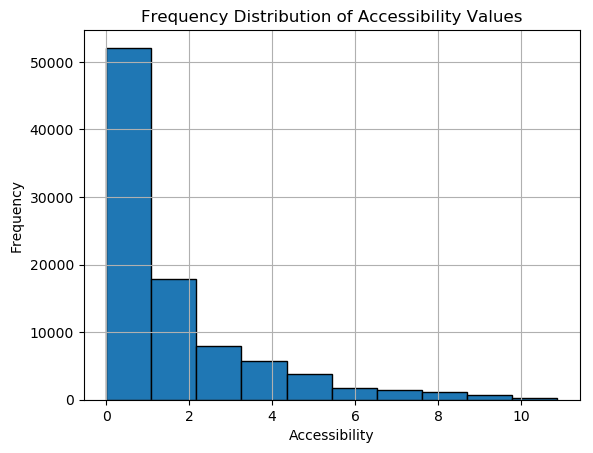

In [13]:
# Check the accessibility value distributions
accessibility_values = [data['accessibility'] for u, v, data in G0.edges(data=True)]

# 绘制频率分布图
plt.hist(accessibility_values, bins=10, edgecolor='black')
plt.title('Frequency Distribution of Accessibility Values')
plt.xlabel('Accessibility')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Consequently, we calculate WDI (Weighted Diversity Index) for each street. It then multiply with accessibility and get the final HSA.

In [15]:
# Calculate WDI for each street

import time
from tqdm import tqdm
import numpy as np
import cupy as cp

def calculate_weighted_diversity_index(G, distance_threshold=500):
    start_time = time.time()
    print("Starting to calculate Weighted Diversity Index...")
    
    # Get all POI nodes and their categories
    poi_nodes = {}
    poi_categories = {}
    for node, data in G.nodes(data=True):
        if 'poi' in data:
            poi_orig_fid = data['ORIG_FID']
            poi_nodes[poi_orig_fid] = node
            poi_categories[poi_orig_fid] = data['fclass']
    
    # Convert POI geometries' bounding boxes to NumPy array
    poi_geometries = np.array([data['geometry'].bounds for node, data in G.nodes(data=True) if 'poi' in data])
    poi_geometries = cp.asarray(poi_geometries)  # Transfer the array to GPU
    
    # Calculate the Weighted Diversity Index for each street
    total_edges = len(G.edges)
    with tqdm(total=total_edges, desc="Processing edges", unit="edge") as pbar:
        for u, v, key, data in G.edges(keys=True, data=True):
            edge_geometry = data['geometry']
            
            # Calculate the midpoint of the street
            midpoint = edge_geometry.interpolate(0.5, normalized=True)
            midpoint_array = cp.array(midpoint.coords[0])  # Transfer midpoint coordinates to GPU
            
            # Get POIs within 500 meters Euclidean distance from the street midpoint
            midpoint_bounds = cp.array([midpoint.x, midpoint.y, midpoint.x, midpoint.y])
            distances = cp.max(cp.abs(poi_geometries - midpoint_bounds), axis=1)  # Calculate maximum distance from midpoint to POI bounding boxes
            nearby_pois = cp.asnumpy(cp.where(distances <= distance_threshold)[0])  # Find POI indexes with distance less than or equal to 500 meters and convert to NumPy array
            
            # Count the number of POIs in each category
            category_counts = {}
            for poi_index in nearby_pois:
                poi_orig_fid = list(poi_nodes.keys())[poi_index]
                category = poi_categories[poi_orig_fid]
                if category in category_counts:
                    category_counts[category] += 1
                else:
                    category_counts[category] = 1
            
            total_pois = sum(category_counts.values())
            
            # Calculate the Weighted Diversity Index
            diversity_index = 0
            for category, count in category_counts.items():
                proportion = count / total_pois
                weight = G.nodes[poi_nodes[list(poi_nodes.keys())[list(poi_categories.values()).index(category)]]]['Normalized_Weight']
                diversity_index += weight * proportion * np.log(1 / proportion)
            
            # Assign the Weighted Diversity Index to the corresponding edge attribute
            G.edges[u, v, key]['weighted_diversity_index'] = diversity_index
            
            pbar.update(1)
    
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Weighted Diversity Index calculation completed. Total execution time: {execution_time:.2f} seconds")
    
    return G

G1 = calculate_weighted_diversity_index(G0, distance_threshold=500)

开始计算Weighted Diversity Index...


Processing edges: 100%|████████████████████████████████████████████████████████| 92869/92869 [41:06<00:00, 37.65edge/s]

Weighted Diversity Index计算完成. 总执行时间: 2466.83 seconds


In [17]:
# Check the WDI value in edges' feature
print("\nSample edges:")
for i, edge in enumerate(G1.edges(data=True)):
    if i < 20:
        print(edge)


Sample edges:
(0, 1, {'FID': 0, 'score_perc': 0.54, 'geometry': <LINESTRING (699648.478 5713925.38, 699631.411 5713914.483, 699620.55 571390...>, 'length': 95.3754863917385, 'accessibility': 0.6556223748544823, 'weighted_diversity_index': 1.7888459187825703})
(1, 28, {'FID': 27, 'score_perc': 0.49, 'geometry': <LINESTRING (699613.814 5713850.686, 699618.31 5713835.047)>, 'length': 16.272451293678824, 'accessibility': 0.7108225643624236, 'weighted_diversity_index': 1.797549952143453})
(2, 3, {'FID': 1, 'score_perc': 0.46, 'geometry': <LINESTRING (699277.923 5713779.008, 699262.303 5713770.318, 699218.663 5713...>, 'length': 181.7904000549609, 'accessibility': 0.07962351159778992, 'weighted_diversity_index': 1.2346487153832488})
(2, 4, {'FID': 2, 'score_perc': 0.43, 'geometry': <LINESTRING (699285.02 5713781.96, 699277.923 5713779.008)>, 'length': 7.686100551485434, 'accessibility': 0.0963109811495682, 'weighted_diversity_index': 1.2808150234553173})
(4, 7, {'FID': 4, 'score_perc': 0.47

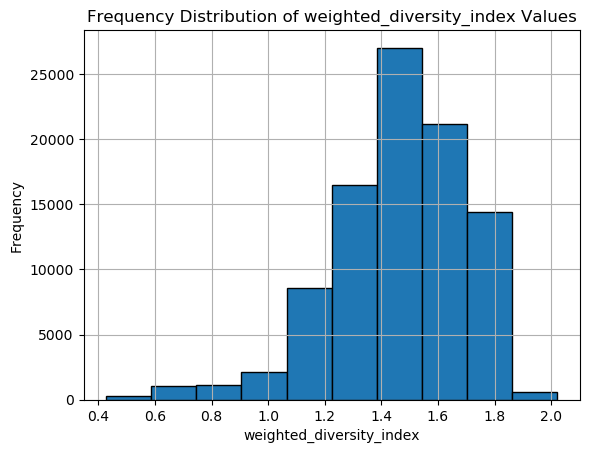

In [19]:
# Check the distribution of WDI
accessibility_values = [data['weighted_diversity_index'] for u, v, data in G1.edges(data=True)]

plt.hist(accessibility_values, bins=10, edgecolor='black')
plt.title('Frequency Distribution of weighted_diversity_index Values')
plt.xlabel('weighted_diversity_index')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [21]:
# Calculate HSA

import time
from tqdm import tqdm

def calculate_hsa(G):
    start_time = time.time()
    print("Starting to calculate HSA...")
    
    total_edges = len(G.edges)
    with tqdm(total=total_edges, desc="Processing edges", unit="edge") as pbar:
        for u, v, key, data in G.edges(keys=True, data=True):
            # Get the accessibility and weighted_diversity_index attribute values of the current edge
            accessibility = data['accessibility']
            weighted_diversity_index = data['weighted_diversity_index']
            
            # Calculate HSA and assign it to the attribute of the current edge
            hsa = accessibility * weighted_diversity_index
            G.edges[u, v, key]['HSA'] = hsa
            
            pbar.update(1)
    
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"HSA calculation completed. Total execution time: {execution_time:.2f} seconds")
    
    return G

G1 = calculate_hsa(G1)

开始计算HSA...


Processing edges: 100%|████████████████████████████████████████████████████| 92869/92869 [00:00<00:00, 668984.35edge/s]

HSA计算完成. 总执行时间: 0.20 seconds


In [23]:
# Check the HSA in edges' features
print("\nSample edges:")
for i, edge in enumerate(G1.edges(data=True)):
    if i < 20:
        print(edge)


Sample edges:
(0, 1, {'FID': 0, 'score_perc': 0.54, 'geometry': <LINESTRING (699648.478 5713925.38, 699631.411 5713914.483, 699620.55 571390...>, 'length': 95.3754863917385, 'accessibility': 0.6556223748544823, 'weighted_diversity_index': 1.7888459187825703, 'HSA': 1.172807409520977})
(1, 28, {'FID': 27, 'score_perc': 0.49, 'geometry': <LINESTRING (699613.814 5713850.686, 699618.31 5713835.047)>, 'length': 16.272451293678824, 'accessibility': 0.7108225643624236, 'weighted_diversity_index': 1.797549952143453, 'HSA': 1.277739066552161})
(2, 3, {'FID': 1, 'score_perc': 0.46, 'geometry': <LINESTRING (699277.923 5713779.008, 699262.303 5713770.318, 699218.663 5713...>, 'length': 181.7904000549609, 'accessibility': 0.07962351159778992, 'weighted_diversity_index': 1.2346487153832488, 'HSA': 0.09830706630851455})
(2, 4, {'FID': 2, 'score_perc': 0.43, 'geometry': <LINESTRING (699285.02 5713781.96, 699277.923 5713779.008)>, 'length': 7.686100551485434, 'accessibility': 0.0963109811495682, 'weig

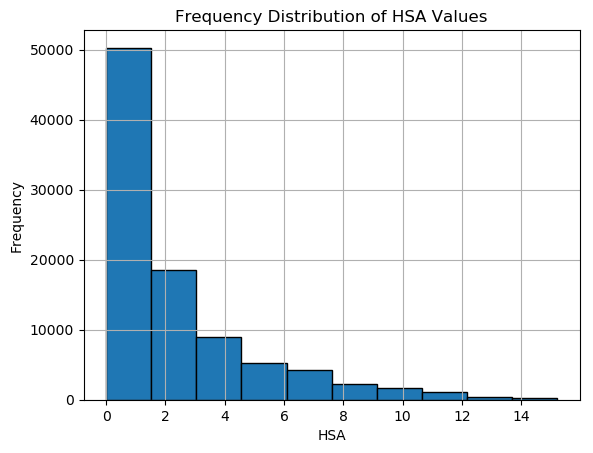

In [25]:
# Check the distribution of HSA
accessibility_values = [data['HSA'] for u, v, data in G1.edges(data=True)]

plt.hist(accessibility_values, bins=10, edgecolor='black')
plt.title('Frequency Distribution of HSA Values')
plt.xlabel('HSA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [27]:
# Save the final file to local
output_file_G1 = "HSA/G1_RA.gpickle"
nx.write_gpickle(G1, output_file_G1)

In [5]:
# Import G1 from local and check the edges
output_file_G1 = "HSA/G1_RA.gpickle"
G1 = nx.read_gpickle(output_file_G1)

print("\nSample edges:")
for i, edge in enumerate(G1.edges(data=True)):
    if i < 20:
        print(edge)


Sample edges:
(0, 1, {'FID': 0, 'score_perc': 0.54, 'geometry': <LINESTRING (699648.478 5713925.38, 699631.411 5713914.483, 699620.55 571390...>, 'length': 95.3754863917385, 'accessibility': 0.6556223748544823, 'weighted_diversity_index': 1.7888459187825703, 'HSA': 1.172807409520977})
(1, 28, {'FID': 27, 'score_perc': 0.49, 'geometry': <LINESTRING (699613.814 5713850.686, 699618.31 5713835.047)>, 'length': 16.272451293678824, 'accessibility': 0.7108225643624236, 'weighted_diversity_index': 1.797549952143453, 'HSA': 1.277739066552161})
(2, 3, {'FID': 1, 'score_perc': 0.46, 'geometry': <LINESTRING (699277.923 5713779.008, 699262.303 5713770.318, 699218.663 5713...>, 'length': 181.7904000549609, 'accessibility': 0.07962351159778992, 'weighted_diversity_index': 1.2346487153832488, 'HSA': 0.09830706630851455})
(2, 4, {'FID': 2, 'score_perc': 0.43, 'geometry': <LINESTRING (699285.02 5713781.96, 699277.923 5713779.008)>, 'length': 7.686100551485434, 'accessibility': 0.0963109811495682, 'weig

In [ ]:
# The final step, we transform the graph to shp with wgs1984 coordination

import geopandas as gpd
from shapely.geometry import LineString
from pyproj import Transformer

def convert_graph_to_wgs84(G, crs_from, crs_to='EPSG:4326'):
    # Create an empty GeoDataFrame to store edge information
    edges_gdf = gpd.GeoDataFrame(columns=['FID', 'geometry', 'accessibility', 'weighted_diversity_index', 'HSA', 'score_perc', 'length'])
    
    # Create a coordinate transformer
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
    
    edge_data = []
    for u, v, key, data in G.edges(keys=True, data=True):
        # Get the geometry object of the edge
        edge_geometry = data['geometry']
        
        # Convert the edge coordinates to WGS1984
        coords = edge_geometry.coords[:]
        transformed_coords = [transformer.transform(x, y) for x, y in coords]
        transformed_geometry = LineString(transformed_coords)
        
        # Get the attributes of the edge
        fid = data['FID']
        accessibility = data['accessibility']
        weighted_diversity_index = data['weighted_diversity_index']
        hsa = data['HSA']
        score_perc = data['score_perc']
        length = data['length']
        
        # Add the transformed geometry and attributes to the data list
        edge_data.append({'FID': fid,
                          'geometry': transformed_geometry,
                          'accessibility': accessibility,
                          'weighted_diversity_index': weighted_diversity_index,
                          'HSA': hsa,
                          'score_perc': score_perc,
                          'length': length})
    
    # Convert the data list to a GeoDataFrame
    edges_gdf = gpd.GeoDataFrame(edge_data)
    
    # Set the coordinate reference system of the GeoDataFrame to WGS1984
    edges_gdf.crs = crs_to
    
    return edges_gdf

# Assume the original coordinate system of G1 is UTM Zone 50N (EPSG:32650)
crs_from = 'EPSG:32650'

# Convert G1 to a GeoDataFrame with WGS1984 coordinate system
G1_wgs84 = convert_graph_to_wgs84(G1, crs_from)

# Save the converted GeoDataFrame as a shp file
output_path = 'human-scale_accessibility/G1_wgs84.shp'
G1_wgs84.to_file(output_path)
print(f"Graph G1 has been converted to WGS1984 coordinate system and saved as a shp file: {output_path}")

Finally, open shp in ArcGIS and you can check all the values. Using ArcGIS to process with the map of category patterns is more convenient.

## 4. Regression Analysis: GLM & GWR

### 4.1 regression analysis with transport emission

In [ ]:
# We output the feature csv from shp, get "RA_HSA.csv".

import pandas as pd

# Read the RA_HSA.csv file
ra_hsa_df = pd.read_csv('regression_analysis/RA_HSA.csv')

# Group RA_HSA.csv by FID and calculate the mean of accessibility, WDI, and HSA
ra_hsa_grouped = ra_hsa_df.groupby('FID').agg({'accessibility': 'mean', 'WDI': 'mean', 'HSA': 'mean'}).reset_index()

# Read the RA_ori.csv file
ra_ori_df = pd.read_csv('regression_analysis/RA_index.csv')

# Merge ra_hsa_grouped with ra_ori_df using FID as the join key
merged_df = pd.merge(ra_ori_df, ra_hsa_grouped, on='FID', how='left')

# Save the result to a new CSV file
merged_df.to_csv('regression_analysis/RA_merged.csv', index=False)
print("Data has been successfully merged and saved to the RA_merged.csv file.")

In [ ]:
# The original transport emission data contains all possible resources, like road, ship, car, van ...
# We simply add them all and get the overall volume.

import pandas as pd

# Define the mapping between filenames and new column names
files_and_columns = {
    'regression_analysis/transport_emission/CO2.csv': 'CO2',
    'regression_analysis/transport_emission/NOx.csv': 'NOx',
    'regression_analysis/transport_emission/PM10.csv': 'PM10',
    'regression_analysis/transport_emission/PM2.5.csv': 'PM2.5'
}

# Initialize an empty DataFrame to store the final result
final_df = None

# Loop through each file and process it
for file, new_column in files_and_columns.items():
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Calculate the sum of columns from the second column to the last column and store it in a new column
    df[new_column] = df.iloc[:, 1:].sum(axis=1)
    
    # If it's the first file, initialize final_df
    if final_df is None:
        final_df = df[['FID', new_column]]
    else:
        # Merge other files with final_df based on the FID column
        final_df = final_df.merge(df[['FID', new_column]], on='FID', how='outer')

# Save the final result to a new CSV file
final_df.to_csv('regression_analysis/transport_emission/Transport_emissions.csv', index=False)

print("Processing completed. The result is saved in Transport_emissions.csv.")

In [3]:
# We calculate the emission per 1km2

TE_A = pd.read_csv('regression_analysis/transport_emission/Transport_emissions.csv')

TE_A['CO2']=TE_A['CO2']/TE_A['Shape_Area']
TE_A['NOx']=TE_A['NOx']/TE_A['Shape_Area']
TE_A['PM10']=TE_A['PM10']/TE_A['Shape_Area']
TE_A['PM2.5']=TE_A['PM2.5']/TE_A['Shape_Area']

TE_A.to_csv('regression_analysis/transport_emission/Transport_emissions_per_area.csv')

In [ ]:
# We applied a geospatial intersection between streets and emission statistical grid. 
# We output the feature csv from shp, get "RA_split_road.csv". Each road belongs to a grid, marked by column 'TARGET_FID'.
# In order to calculate the average value of HSA in each grid.

# Read the CSV file
file_path = 'regression_analysis/transport_emission/RA_split_road.csv'
df = pd.read_csv(file_path)

# Ensure the column names match the ones in the CSV file
columns_to_average = ['score_perc', 'accessibility', 'WDI', 'HSA']
group_column = 'TARGET_FID'

# Group and calculate the mean values
grouped_df = df.groupby(group_column)[columns_to_average].mean().reset_index()

# Save the result to a new CSV file
output_file = 'regression_analysis/transport_emission/RA_split_road_0.csv'
grouped_df.to_csv(output_file, index=False)

print(f"Processing completed. The result is saved in {output_file}.")

In [17]:
# Calculate median and std of 4 transport emissions. Have a look at the data value

# 'transport_emission_data.csv' the file is a final version including transport emission and HSA, WDI... we mannually organised in Excel.
# It should be same to 'RA_emission_HSA.csv' at this stage
df = pd.read_csv('regression_analysis/transport_emission/transport_emission_data.csv')

CO2_mean_score = df['CO2_km2'].mean()
CO2_median_score = df['CO2_km2'].median()
CO2_sd_score = df['CO2_km2'].std()

NOx_mean_score = df['NOx_km2'].mean()
NOx_median_score = df['NOx_km2'].median()
NOx_sd_score = df['NOx_km2'].std()

PM10_mean_score = df['PM10_km2'].mean()
PM10_median_score = df['PM10_km2'].median()
PM10_sd_score = df['PM10_km2'].std()

PM25_mean_score = df['PM25_km2'].mean()
PM25_median_score = df['PM25_km2'].median()
PM25_sd_score = df['PM25_km2'].std()


# print
print(f"CO2_mean_score: {CO2_mean_score:.4f}")
print(f"CO2_median_score: {CO2_median_score:.4f}")
print(f"CO2_sd_score: {CO2_sd_score:.4f}")
print("---")

print(f"NOx_mean_score: {NOx_mean_score:.4f}")
print(f"NOx_median_score: {NOx_median_score:.4f}")
print(f"NOx_sd_score: {NOx_sd_score:.4f}")
print("---")

print(f"PM10_mean_score: {PM10_mean_score:.4f}")
print(f"PM10_median_score: {PM10_median_score:.4f}")
print(f"PM10_sd_score: {PM10_sd_score:.4f}")
print("---")

print(f"PM25_mean_score: {PM25_mean_score:.4f}")
print(f"PM25_median_score: {PM25_median_score:.4f}")
print(f"PM25_sd_score: {PM25_sd_score:.4f}")
print("---")

CO2_mean_score: 139326.3087
CO2_median_score: 85323.7171
CO2_sd_score: 174339.9687
---
NOx_mean_score: 485.7072
NOx_median_score: 268.7860
NOx_sd_score: 582.2873
---
PM10_mean_score: 41.2933
PM10_median_score: 25.7853
PM10_sd_score: 48.0384
---
PM25_mean_score: 23.2286
PM25_median_score: 14.3378
PM25_sd_score: 25.7241
---


We then apply GLM to analyse the relationship of HSA and trasprot eissmions

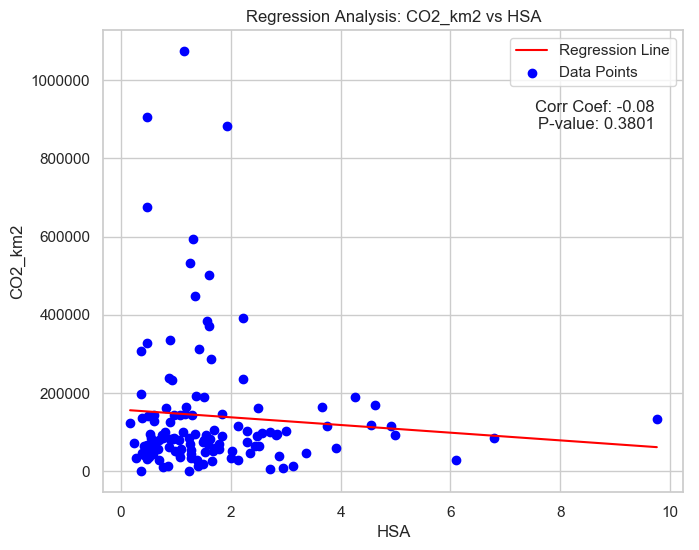

Correlation Coefficient (HSA vs CO2_km2): -0.08
P-value (HSA vs CO2_km2): 0.3801
------------------------


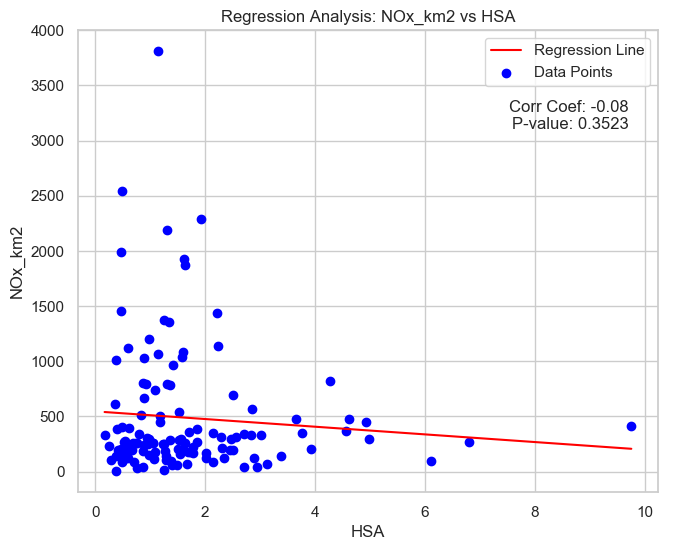

Correlation Coefficient (HSA vs NOx_km2): -0.08
P-value (HSA vs NOx_km2): 0.3523
------------------------


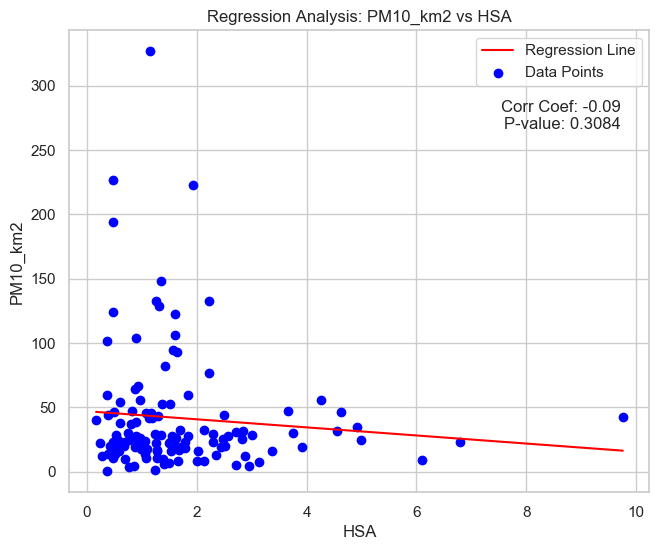

Correlation Coefficient (HSA vs PM10_km2): -0.09
P-value (HSA vs PM10_km2): 0.3084
------------------------


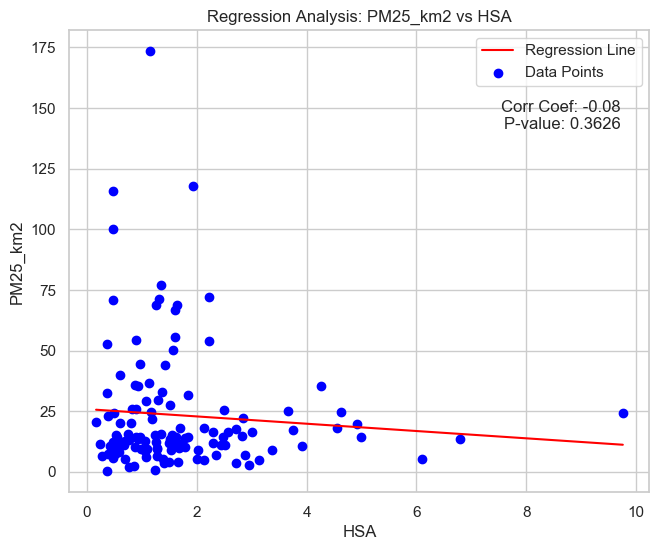

Correlation Coefficient (HSA vs PM25_km2): -0.08
P-value (HSA vs PM25_km2): 0.3626
------------------------


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Read the CSV file
data = pd.read_csv('regression_analysis/transport_emission/RA_emission_HSA.csv') # We mannualy match the data in Excel, merging the HSA, WDI... with transport emissions

# Define the list of dependent variables
dependent_vars = ['CO2_km2', 'NOx_km2', 'PM10_km2', 'PM25_km2']

# Extract the independent variable data
x = data['HSA']

# Loop through each dependent variable
for var in dependent_vars:
    # Extract the data for the current dependent variable
    y = data[var]
    
    # Calculate the Pearson correlation coefficient and p-value
    corr_coef, p_value = stats.pearsonr(x, y)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Generate data points for the fitted line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    
    # Create a scatter plot and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', label='Data Points')
    plt.plot(x_line, y_line, color='red', label='Regression Line')
    plt.xlabel('HSA')
    plt.ylabel(var)
    plt.title(f'Regression Analysis: {var} vs HSA')
    
    # Display the legend and p-value in the bottom right corner
    plt.legend(loc='upper right')
    plt.text(0.95, 0.85, f'Corr Coef: {corr_coef:.2f}\nP-value: {p_value:.4f}',
             fontsize=12, ha='right', va='top', transform=plt.gca().transAxes)
    
    # Adjust the plot margins
    plt.subplots_adjust(right=0.85)
    
    # Save the plot as an image file
    plt.savefig(f'regression_{var}_vs_HSA.png')
    
    # Display the plot
    plt.show()
    
    # Print the correlation coefficient and p-value
    print(f"Correlation Coefficient (HSA vs {var}): {corr_coef:.2f}")
    print(f"P-value (HSA vs {var}): {p_value:.4f}")
    print("------------------------")

All p-value above 0.05, so not one has relationship. We then try to tansform the variables to log, hope to capture their non-linear relations.

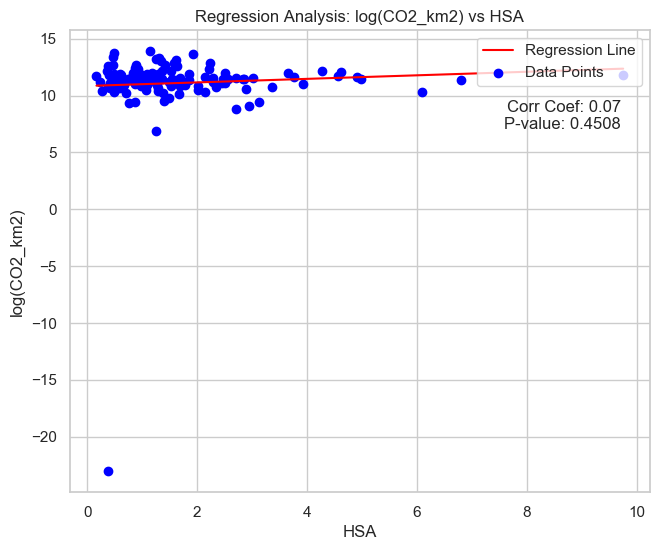

Correlation Coefficient (HSA vs log(CO2_km2)): 0.07
P-value (HSA vs log(CO2_km2)): 0.4508
------------------------


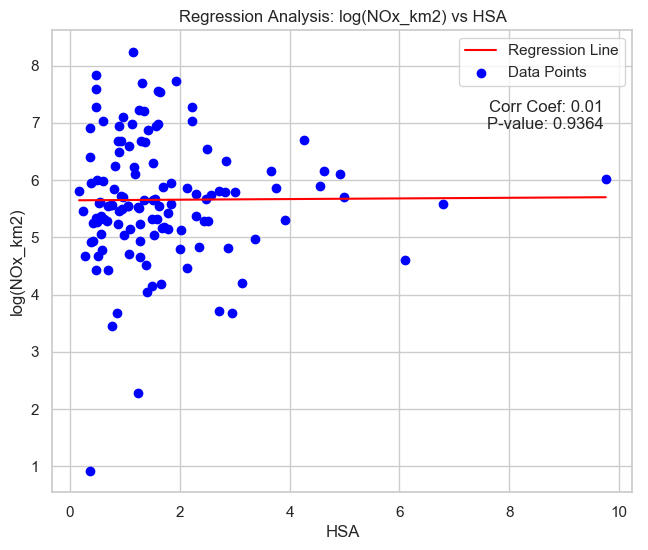

Correlation Coefficient (HSA vs log(NOx_km2)): 0.01
P-value (HSA vs log(NOx_km2)): 0.9364
------------------------


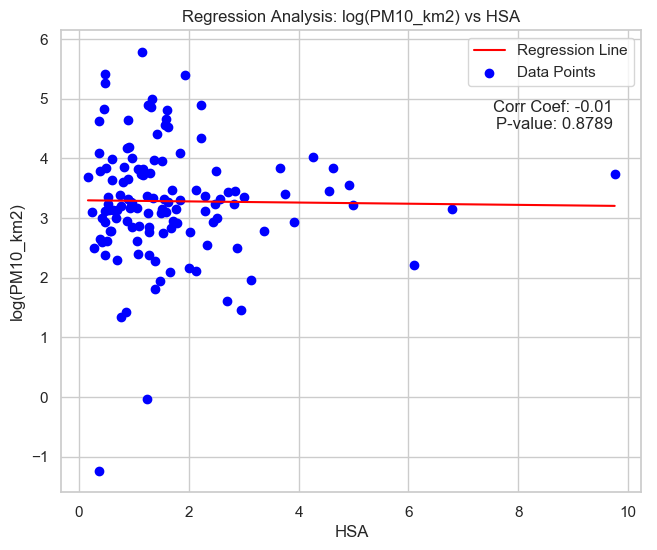

Correlation Coefficient (HSA vs log(PM10_km2)): -0.01
P-value (HSA vs log(PM10_km2)): 0.8789
------------------------


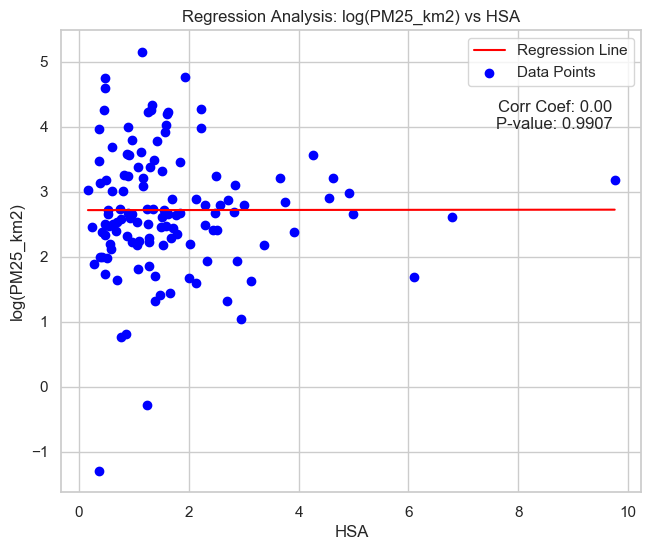

Correlation Coefficient (HSA vs log(PM25_km2)): 0.00
P-value (HSA vs log(PM25_km2)): 0.9907
------------------------


In [62]:
# Convert the dependent variables to log form

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Read the CSV file
data = pd.read_csv('regression_analysis/transport_emission/RA_emission_HSA.csv')

# Define the list of dependent variables
dependent_vars = ['CO2_km2', 'NOx_km2', 'PM10_km2', 'PM25_km2']

# Extract the independent variable data
x = data['HSA']

# Loop through each dependent variable
for var in dependent_vars:
    # Extract the data for the current dependent variable
    y = data[var]
    
    # Replace zero or negative values with a small positive value (e.g., 1e-10)
    y = np.where(y <= 0, 1e-10, y)
    
    # Convert the data to logarithmic form
    y = np.log(y)
    
    # Calculate the Pearson correlation coefficient and p-value
    corr_coef, p_value = stats.pearsonr(x, y)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Generate data points for the fitted line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    
    # Create a scatter plot and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', label='Data Points')
    plt.plot(x_line, y_line, color='red', label='Regression Line')
    plt.xlabel('HSA')
    plt.ylabel(f'log({var})')
    plt.title(f'Regression Analysis: log({var}) vs HSA')
    
    # Display the legend and p-value in the bottom right corner
    plt.legend(loc='upper right')
    plt.text(0.95, 0.85, f'Corr Coef: {corr_coef:.2f}\nP-value: {p_value:.4f}',
             fontsize=12, ha='right', va='top', transform=plt.gca().transAxes)
    
    # Adjust the plot margins
    plt.subplots_adjust(right=0.85)
    
    # Save the plot as an image file
    plt.savefig(f'regression_log_{var}_vs_HSA.png')
    
    # Display the plot
    plt.show()
    
    # Print the correlation coefficient and p-value
    print(f"Correlation Coefficient (HSA vs log({var})): {corr_coef:.2f}")
    print(f"P-value (HSA vs log({var})): {p_value:.4f}")
    print("------------------------")

The results show there still no relationship, all p-value above 0.05.

Ok, no relation is kind of relation, we still got something to discuss. Then we beautify the plots and save them to local.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import os

data = pd.read_csv('regression_analysis/transport_emission/transport_emission_HSA.csv')

# Create a folder named "GLM_plots_Eco-Green" (if it doesn't exist)
folder_name = "regression_analysis/transport_emission/GLM_plots_emission"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the columns for y-axis and x-axis
y_columns = ['CO2_km2', 'NOx_km2', 'PM10_km2', 'PM25_km2']
x_columns = ['HSA', 'score_perc', 'accessibility', 'WDI']

# Create a 4x4 grid of subplots and adjust the figure width
fig, axes = plt.subplots(4, 4, figsize=(30, 20), dpi=300)

# Plot scatter plots and perform GLM modeling
for i, y_col in enumerate(y_columns):
    for j, x_col in enumerate(x_columns):
        ax = axes[i, j]
        
        # Plot scatter plot
        ax.scatter(data[x_col], data[y_col], alpha=0.5, label='Observed')
        
        # Perform GLM modeling
        X = sm.add_constant(data[x_col])
        model = sm.GLM(data[y_col], X, family=sm.families.Gaussian())
        results = model.fit()
        
        # Generate data points for the fitted curve
        x_min, x_max = data[x_col].min(), data[x_col].max()
        x_range = np.linspace(x_min, x_max, 100)
        X_pred = sm.add_constant(x_range)
        y_pred = results.predict(X_pred)
        
        # Plot the fitted curve
        ax.plot(x_range, y_pred, color='red', label='Regression line')
        
        # Create legend labels
        coef = results.params.iloc[1]
        pvalue = results.pvalues.iloc[1]
        aic = results.aic
        bic = results.bic
        
        label = f'Coef: {coef:.3f}\n' \
                f'P-value: {pvalue:.3f}\n' \
                f'AIC: {aic:.3f}\n' \
                f'BIC: {bic:.3f}'
        
        # Add complete legend information to the upper right corner of the plot
        ax.legend([plt.Line2D([0], [0], color='red', lw=2)], [label], loc='upper right', bbox_to_anchor=(0.98, 0.98), borderaxespad=0, fontsize=8)
        
        ax.set_title(f'{y_col} vs {x_col}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.grid(True)
        
        # Adjust the aspect ratio of x-axis and y-axis to be slightly narrower
        ax.set_aspect(1.0/ax.get_data_ratio()*0.7)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the merged image locally
file_name = 'GLM_emission_4x4_full_legend.png'
plt.savefig(file_name)

plt.close(fig)  # Close the figure to release memory

### 4.2 Regression analysis with Socio-Green indicators

In [10]:
# Similarly, We applied a geospatial intersection between streets and LSOA boundary. 
# We output the feature csv from shp, get "2021_LSOA_join.csv". Each road belongs to a LSOA, marked by column 'TARGET_FID'.
# In order to calculate the average value of HSA in each grid.

import pandas as pd

data = pd.read_csv('regression_analysis/socio-green_indicators/2021_LSOA_join.csv')

# Based on TARGET_FID group，calculate the mean value of HSA, WDI, accessibility, score_perc
grouped_data = data.groupby('TARGET_FID')[['HSA', 'WDI', 'accessibility', 'score_perc']].mean().reset_index()

# export to CSV
grouped_data.to_csv('regression_analysis/socio-green_indicators/2021_LSOA_HSA.csv', index=False)

print("Grouped data has been successfully saved to 'grouped_data.csv'.")

Grouped data has been successfully saved to 'grouped_data.csv'.


In [16]:
# We have calculated each indicator in Excel, and got the folloing 4 csv files.
# Then we merge them together

file_A = pd.read_csv('regression_analysis/socio-green_indicators/2021_LSOA_HSA.csv')
file_B = pd.read_csv('regression_analysis/socio-green_indicators/2021-Car-lsoa.csv')
file_C = pd.read_csv('regression_analysis/socio-green_indicators/2021-commute-lsoa.csv')
file_D = pd.read_csv('regression_analysis/socio-green_indicators/2021-health-lsoa.csv')
file_E = pd.read_csv('regression_analysis/socio-green_indicators/2021-homeDeprivation-lsoa.csv')


# Merge all of them
merged_data = file_A.merge(file_B[['geography code', 'no_cars_perc']], 
                           left_on='LSOA21CD', 
                           right_on='geography code', 
                           how='left').drop(columns=['geography code'])


merged_data = merged_data.merge(file_C[['geography code', 'green_commute_ratio']], 
                                left_on='LSOA21CD', 
                                right_on='geography code', 
                                how='left').drop(columns=['geography code'])


merged_data = merged_data.merge(file_D[['geography code', 'health_perc']], 
                                left_on='LSOA21CD', 
                                right_on='geography code', 
                                how='left').drop(columns=['geography code'])


merged_data = merged_data.merge(file_E[['geography code', 'no_deprivation_perc']], 
                                left_on='LSOA21CD', 
                                right_on='geography code', 
                                how='left').drop(columns=['geography code'])

# Save csv
merged_data.to_csv('regression_analysis/socio-green_indicators/LSOA_analysis.csv', index=False)

print("Merged data has been successfully saved to 'merged_data.csv'.")

Merged data has been successfully saved to 'merged_data.csv'.


In [13]:
# We then match the Socio-Green indicators (merged_data.csv) with 2021_LSOA_CAZ_HSA.csv
# get a final csv (LSOA_analysis.csv) for analysing Socio-Green indicators and HSA ...
# Output the mean, median, std of socio-green indicators

df = pd.read_csv('regression_analysis/socio-green_indicators/LSOA_analysis.csv')

nocar_mean_score = df['no_cars_perc'].mean()
nocar_median_score = df['no_cars_perc'].median()
nocar_sd_score = df['no_cars_perc'].std()

greenc_mean_score = df['green_commute_perc'].mean()
greenc_median_score = df['green_commute_perc'].median()
greenc_sd_score = df['green_commute_perc'].std()

healthp_mean_score = df['health_perc'].mean()
healthp_median_score = df['health_perc'].median()
healthp_sd_score = df['health_perc'].std()

nodepriv_mean_score = df['no_deprivation_perc'].mean()
nodepriv_median_score = df['no_deprivation_perc'].median()
nodepriv_sd_score = df['no_deprivation_perc'].std()

# print
print(f"nocar_mean_score: {nocar_mean_score:.4f}")
print(f"nocar_median_score: {nocar_median_score:.4f}")
print(f"nocar_sd_score: {nocar_sd_score:.4f}")
print("---")

print(f"greenc_mean_score: {greenc_mean_score:.4f}")
print(f"greenc_median_score: {greenc_median_score:.4f}")
print(f"greenc_sd_score: {greenc_sd_score:.4f}")
print("---")

print(f"healthp_mean_score: {healthp_mean_score:.4f}")
print(f"healthp_median_score: {healthp_median_score:.4f}")
print(f"healthp_sd_score: {healthp_sd_score:.4f}")
print("---")

print(f"nodepriv_mean_score: {nodepriv_mean_score:.4f}")
print(f"nodepriv_median_score: {nodepriv_median_score:.4f}")
print(f"nodepriv_sd_score: {nodepriv_sd_score:.4f}")
print("---")

nocar_mean_score: 0.7010
nocar_median_score: 0.7143
nocar_sd_score: 0.0909
---
greenc_mean_score: 0.7157
greenc_median_score: 0.7357
greenc_sd_score: 0.0928
---
healthp_mean_score: 0.8648
healthp_median_score: 0.8647
healthp_sd_score: 0.0498
---
nodepriv_mean_score: 0.5147
nodepriv_median_score: 0.5191
nodepriv_sd_score: 0.1260
---


C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

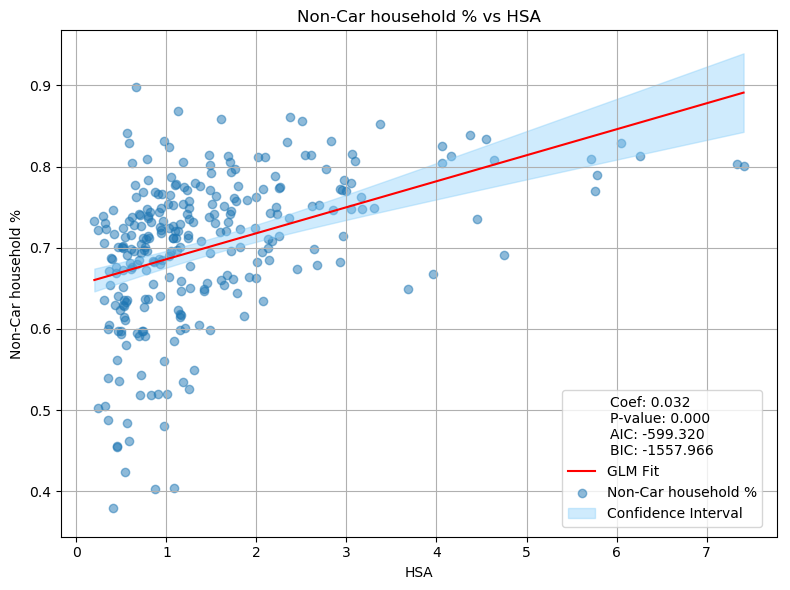

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

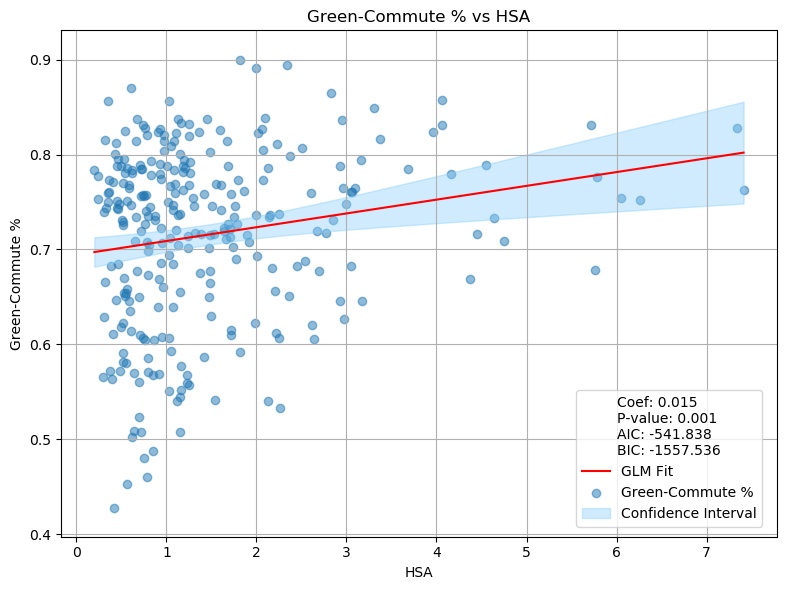

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

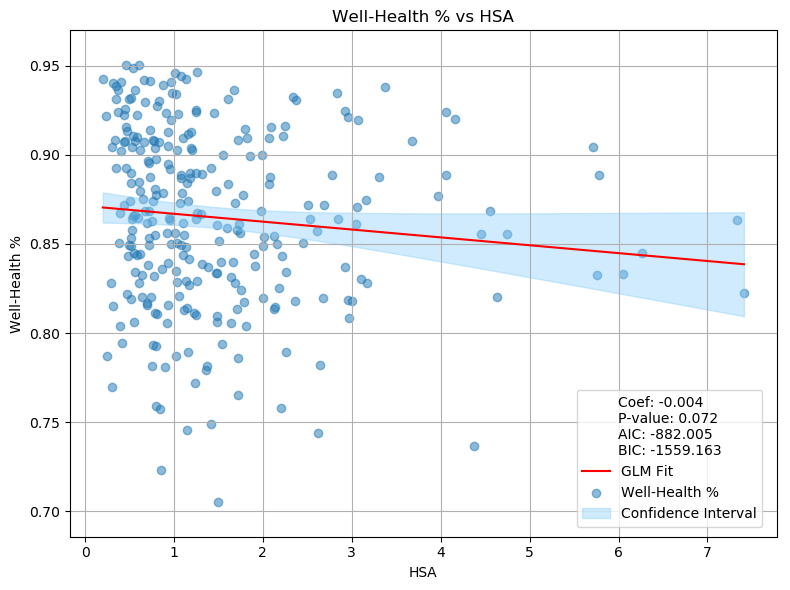

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

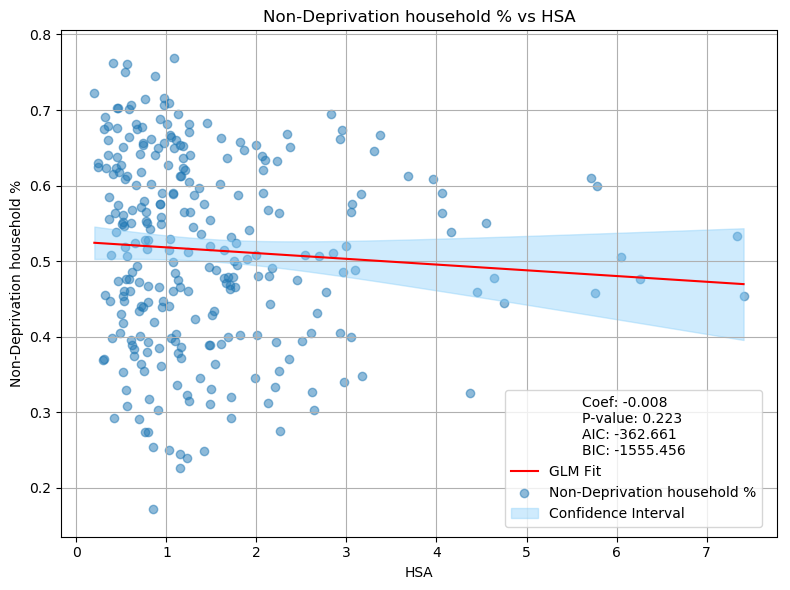

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

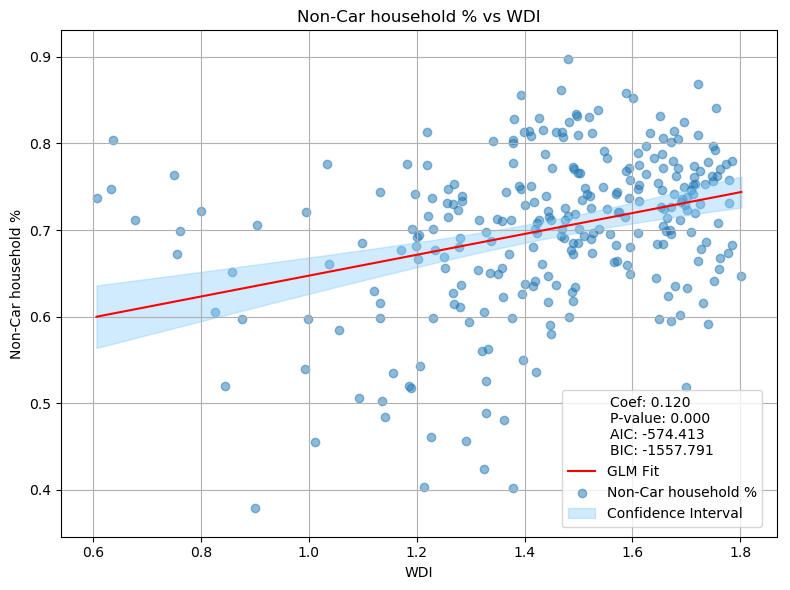

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

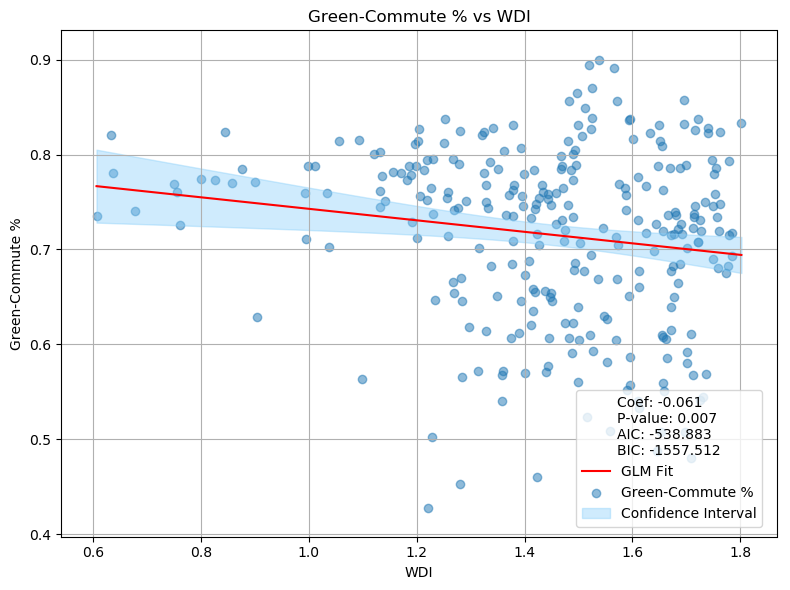

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

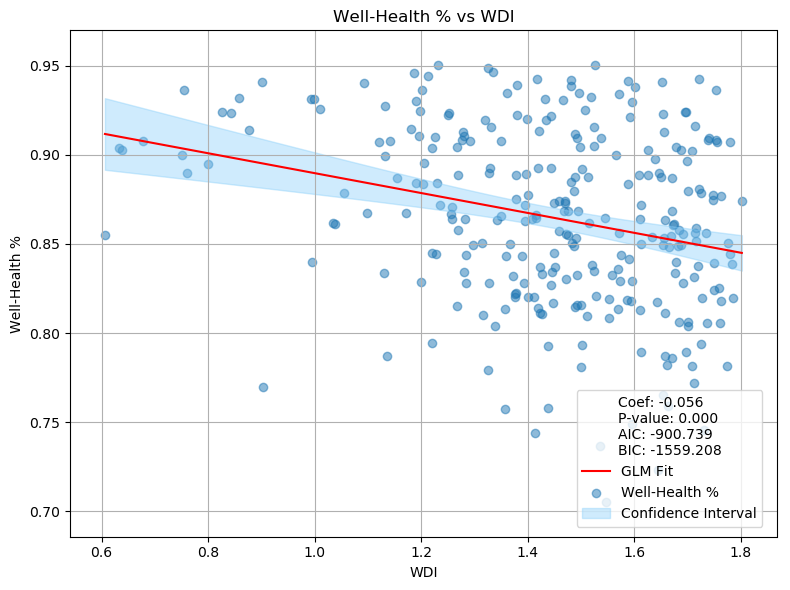

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

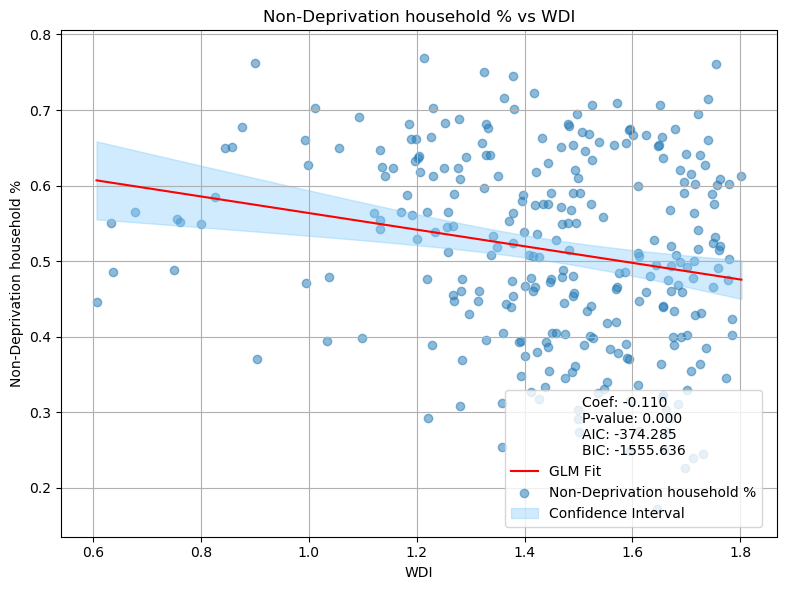

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

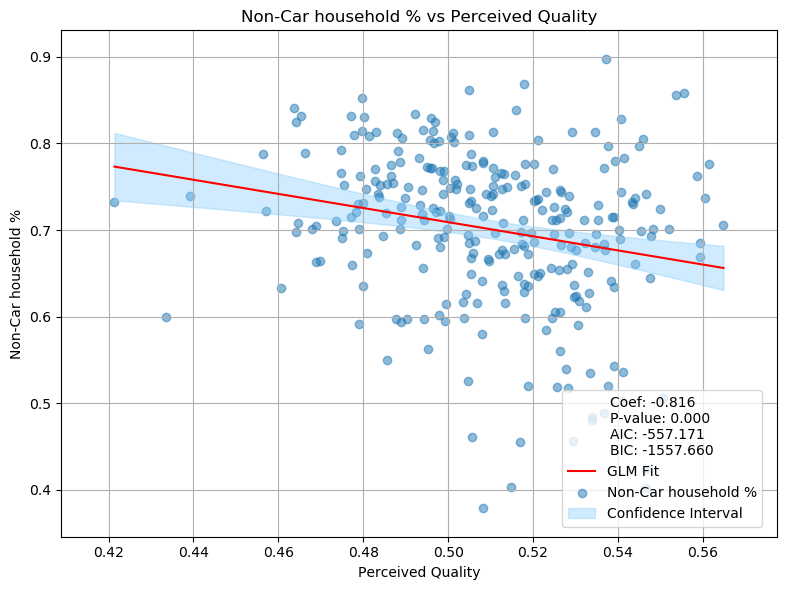

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

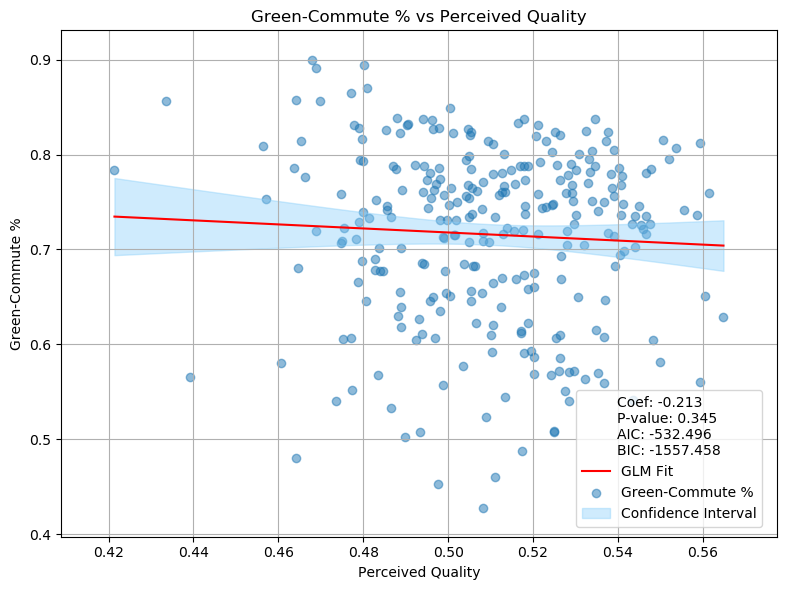

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

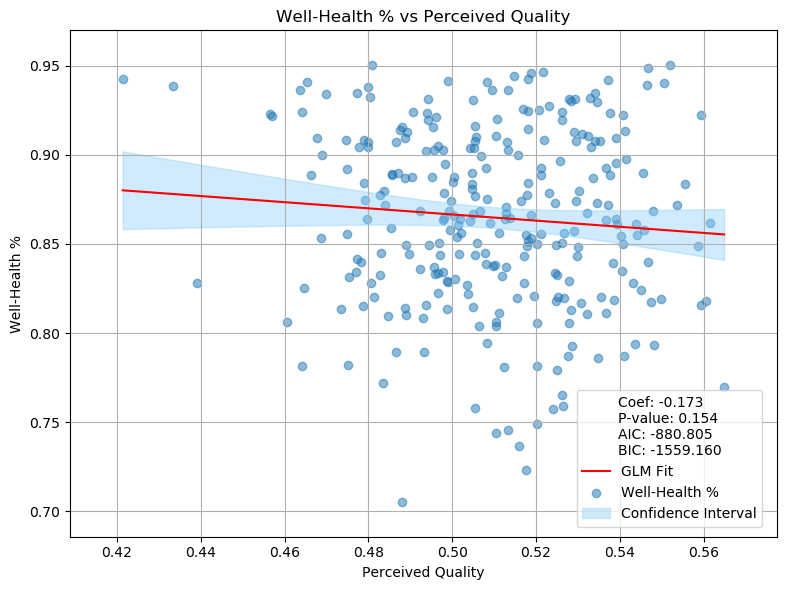

C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = results.params[1]
C:\Users\99787\AppData\Local\Temp\ipykernel_864\3030013790.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = results.pvalues[1]
F:\ANACONDA\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version us

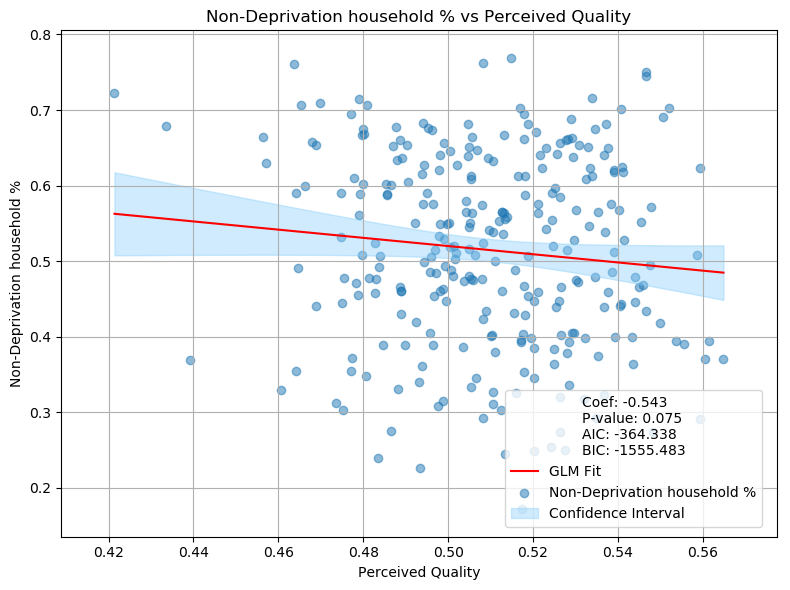

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import os

# Create a folder named "GLM_plots_Eco-Green" (if it doesn't exist)
folder_name = "regression_analysis/socio-green_indicators/GLM_plots_Eco-Green"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Read the CSV file
data = pd.read_csv('LSOA_analysis.csv')

# Define independent variables and dependent variables
x_vars = ['HSA', 'WDI', 'score_perc']
y_vars = ['no_cars_perc', 'green_commute_perc', 'health_perc', 'no_deprivation_perc']

# Define variable name mappings
var_names = {
    'no_cars_perc': 'Non-Car household %',
    'green_commute_perc': 'Green-Commute %',
    'health_perc': 'Well-Health %',
    'no_deprivation_perc': 'Non-Deprivation household %',
    'score_perc': 'Perceived Quality',
    'HSA': 'HSA',
    'WDI': 'WDI'
}

# Iterate over independent variables and dependent variables to plot scatter plots and GLM fit curves
for i, x_var in enumerate(x_vars):
    for j, y_var in enumerate(y_vars):
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Plot scatter plot
        ax.scatter(data[x_var], data[y_var], alpha=0.5, label=var_names[y_var])
        
        # Perform GLM modeling
        X = sm.add_constant(data[x_var])
        model = sm.GLM(data[y_var], X, family=sm.families.Gaussian())
        results = model.fit()
        
        # Generate data points for the fitted curve
        x_min, x_max = data[x_var].min(), data[x_var].max()
        x_range = np.linspace(x_min, x_max, 100)
        X_pred = sm.add_constant(x_range)
        y_pred = results.predict(X_pred)
        
        # Plot the fitted curve
        ax.plot(x_range, y_pred, color='red', label='GLM Fit')
        
        # Calculate confidence interval
        ci = results.get_prediction(X_pred).conf_int(alpha=0.05)
        
        # Plot the confidence interval
        ax.fill_between(x_range, ci[:, 0], ci[:, 1], color='lightskyblue', alpha=0.4, label='Confidence Interval')
        
        # Create legend labels
        coef = results.params[1]
        pvalue = results.pvalues[1]
        aic = results.aic
        bic = results.bic
        
        label = f'Coef: {coef:.3f}\n' \
                f'P-value: {pvalue:.3f}\n' \
                f'AIC: {aic:.3f}\n' \
                f'BIC: {bic:.3f}'
        
        # Add legend
        ax.legend(loc='lower right', bbox_to_anchor=(0.98, 0.02), borderaxespad=0, fontsize=10, title=label)
        
        ax.set_title(f'{var_names[y_var]} vs {var_names[x_var]}')
        ax.set_xlabel(var_names[x_var])
        ax.set_ylabel(var_names[y_var])
        ax.grid(True)
        
        # Save the plot to the folder "GLM_plots_Eco-Green"
        plt.tight_layout()
        plt.savefig(os.path.join(folder_name, f'{var_names[y_var]}_vs_{var_names[x_var]}.png'))
        
        # Display the plot
        plt.show()

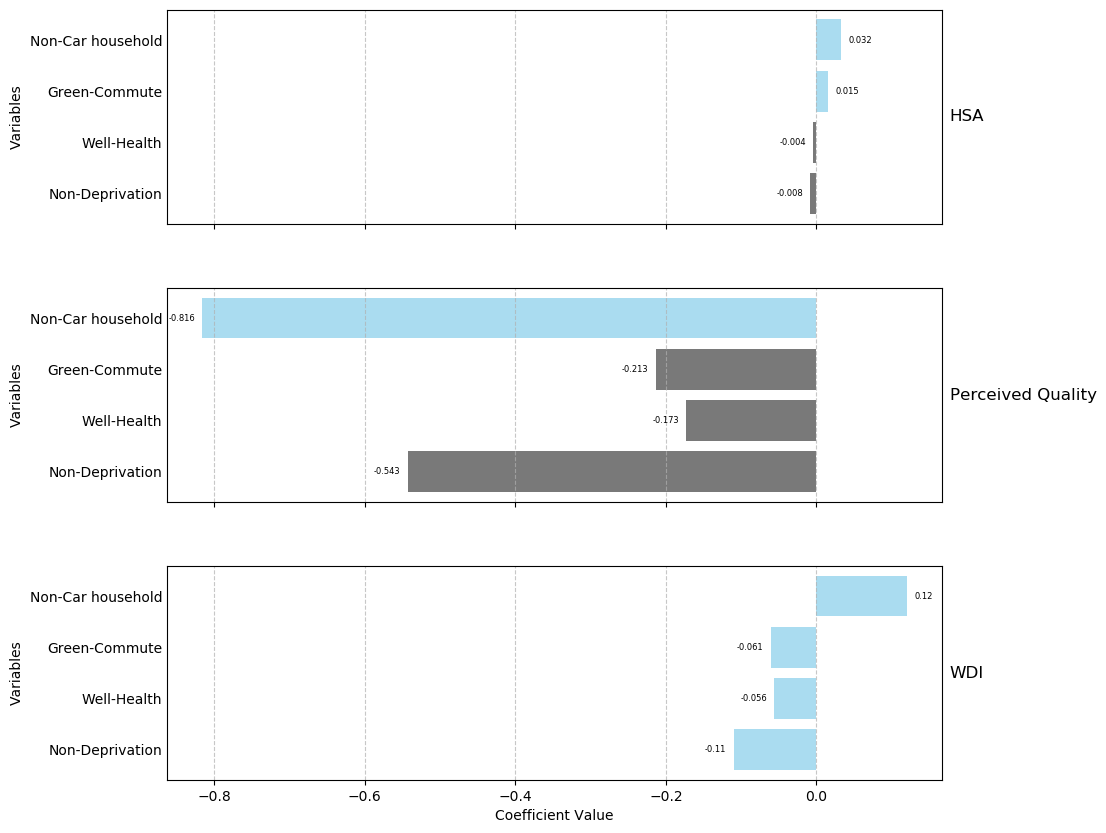

In [75]:
# Draw a coefficient bar plot

import matplotlib.pyplot as plt
import pandas as pd

# Read the csv file
data = pd.read_csv('regression_analysis/socio-green_indicators/eco-green-coef.csv', index_col=0)

# Set the figure size and layout
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Define sky blue and dark gray colors
color_blue = '#87CEEB'
color_gray = '#404040'

# Define the sorting order
order = ['Non-Deprivation', 'Well-Health', 'Green-Commute', 'Non-Car household']

# Rearrange the data according to the specified order
data = data[order]

# Plot horizontal bar charts for each row
for i, row in enumerate(data.index):
    row_data = data.loc[row]
    colors = [color_gray] * len(order)  # Initialize bar colors to dark gray
    
    # Set bar colors to sky blue based on conditions
    if row == 'HSA':
        colors[-2:] = [color_blue] * 2
    elif row == 'Perceived Quality':
        colors[-1] = color_blue
    elif row == 'WDI':
        colors = [color_blue] * len(order)
    
    axes[i].barh(order, row_data, color=colors, alpha=0.7)
    
    # Set y-axis labels
    axes[i].set_ylabel('Variables')
    
    # Adjust the position of y-axis labels
    axes[i].tick_params(axis='y', which='both', length=0)
    axes[i].yaxis.set_ticks_position('none')
    
    # Add value labels
    for j, v in enumerate(row_data):
        if v >= 0:
            axes[i].text(v + 0.01, j, str(round(v, 3)), color='black', va='center', fontsize=6, ha='left')
        else:
            axes[i].text(v - 0.01, j, str(round(v, 3)), color='black', va='center', fontsize=6, ha='right')
    
    # Add row labels
    axes[i].text(1.01, 0.5, row, transform=axes[i].transAxes, fontsize=12, va='center')

# Set the shared x-axis label
axes[-1].set_xlabel('Coefficient Value')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Add grid lines
for ax in axes:
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Save the figure locally
plt.savefig('eco_green_coef.png', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()

We further employed GWR but through ArcGIS (more convenient, python is not good at spatial analysis), so we have no coding demonstrating here.

Basically, all the coding related to my MSc dissertation "Quantifying 15-Minute City Spatial Structure: 
Exploring Its Influence on Transport Emissions in London's CAZ is shown here. More contents please find my dissertation text, where I do all the discussions of the results.

The most important part is the HSA calculation. I really learned a lot about network analysis by doing this project. It sounds not difficult about the calculation logic of HSA, but so hard to realise it, I have made a lot of mistakes and walked through many detour. Fortunately, it finnally worked. 

Please note that a significant amount of work was done using ArcGIS, Excel, Photoshop, Word, and other software, which is not reflected in this file. Therefore, the full scope of the workload extends beyond what is shown here.

For this moment, HSA should be the first indicator to measure 15-min city level at street scale. It still has a lot room to optimise, which I discuss in my dissertation. I hope this indicator can have opportunity to benefit policy making and have positive impact to urban development."